In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import & Install Library

In [ ]:
!pip install googletrans==4.0.0-rc1

In [ ]:
import json
import random
import time
from tqdm import tqdm
from googletrans import Translator

# # ==================================================
# # 📘 Load dictionary lokal (KBBI-based)
# # ==================================================
def load_dict(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)

dict_path = "/content/drive/MyDrive/Dataset Emotion Classification/dict.json"
mydict = load_dict(dict_path)

# # ==================================================
# # 🔤 Fungsi bantu sinonim dan antonim
# # ==================================================
def getSinonim(word):
    word = word.lower().strip()
    return mydict.get(word, {}).get("sinonim", [])

def getAntonim(word):
    word = word.lower().strip()
    return mydict.get(word, {}).get("antonim", [])

# # ==================================================
# # 🪄 1. Synonym Replacement (SR)
# # ==================================================
# # ==================================================
# # 🪄 1. Synonym Replacement (SR) — versi iterative
# # ==================================================
def synonym_replacement(text, replace_rate=0.2, loops=1):
    results = []
    for _ in range(loops):
        words = text.split()  # mulai dari teks asli setiap loop
        n_replace = max(1, int(len(words) * replace_rate))
        candidates = [i for i, w in enumerate(words) if getSinonim(w)]
        if not candidates:
            results.append(text)
            continue
        idx_to_replace = random.sample(candidates, min(n_replace, len(candidates)))
        for idx in idx_to_replace:
            synonyms = getSinonim(words[idx])
            words[idx] = random.choice(synonyms)
        results.append(" ".join(words))
    return results

# # ==================================================
# # ✍️ 2. Random Insertion (RI)
# # ==================================================
# def random_insertion(text, insert_rate=0.2):
#     words = text.split()
#     if not words:
#         return text
#     n_insert = max(1, int(len(words) * insert_rate))
#     for _ in range(n_insert):
#         w = random.choice(words)
#         synonyms = getSinonim(w)
#         if synonyms:
#             insert_word = random.choice(synonyms)
#             insert_pos = random.randint(0, len(words))
#             words.insert(insert_pos, insert_word)
#     return " ".join(words)

# # ==================================================
# # 🔄 3. Random Swap (RS)
# # ==================================================
# def random_swap(text, swap_rate=0.2):
#     words = text.split()
#     if len(words) < 2:
#         return text
#     n_swap = max(1, int(len(words) * swap_rate))
#     for _ in range(n_swap):
#         i, j = random.sample(range(len(words)), 2)
#         words[i], words[j] = words[j], words[i]
#     return " ".join(words)

# # ==================================================
# # ❌ 4. Random Deletion (RD)
# # ==================================================
# def random_deletion(text, delete_rate=0.2):
#     words = text.split()
#     if len(words) == 1:
#         return text
#     new_words = [w for w in words if random.random() > delete_rate]
#     if not new_words:
#         new_words = [random.choice(words)]
#     return " ".join(new_words)

# # ==================================================
# # 🌐 5. Back Translation (multi-loop)
# # ==================================================
translator = Translator()

def back_translation(text, src='id', mid='en', loops=2, sleep_time=0.5):
    current_text = text
    for i in range(loops):
        try:
            en = translator.translate(current_text, src=src, dest=mid).text
            time.sleep(sleep_time)
            back = translator.translate(en, src=mid, dest=src).text
            current_text = back
            time.sleep(sleep_time)
        except Exception as e:
            print(f"⚠️ Error di loop {i+1}: {e}")
            break
    return current_text

# # ==================================================
# # 🚀 Contoh Data
# # ==================================================
# texts = [
#     "AKU KASIH BINTANG 4 DLU SOALNYA GAMENYA BANYAK BUG NYA CONTOH BUG NYA KADANG SUKA STUCK SAAT LOADING",
#     "APLIKASINYA LAG PARAH, TOLONG DIBENERIN CEPAT YA",
#     "FITURNYA BAGUS TAPI TERLALU SERING CRASH",
# ]

# # ==================================================
# # 🧠 Jalankan Augmentasi
# # ==================================================
# for t in texts:
#     print("\n🟩 Teks Asli:", t)
#     sr_results = synonym_replacement(t, loops=3)  # contoh 3 kali loop
#     for i, sr in enumerate(sr_results, 1):
#         print(f"🔹 SR Loop {i}:", sr)
#     print("🔹 RI:", random_insertion(t))
#     print("🔹 RS:", random_swap(t))
#     print("🔹 RD:", random_deletion(t))
#     print("🔹 BT:", back_translation(t, loops=1))

In [ ]:
!pip install transformers datasets torch pandas scikit-learn accelerate evaluate optuna peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 18.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd

In [ ]:
import re

# Data Collection

In [ ]:
DATA_FILE = "/content/drive/MyDrive/Dataset Emotion Classification/PRDECT-ID Dataset.csv"

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
print(f"Mencoba memuat data dari: {DATA_FILE}")
try:
    df = pd.read_csv(DATA_FILE)
    print("Data berhasil dimuat")
except FileNotFoundError:
    print(f"Error: File dataset '{DATA_FILE}' tidak ditemukan.")
    print("Pastikan path dan nama file Anda di Google Drive sudah benar.")
    raise

Mencoba memuat data dari: /content/drive/MyDrive/Dataset Emotion Classification/PRDECT-ID Dataset.csv
Data berhasil dimuat


In [ ]:
df = df[['Customer Review', 'Emotion']]
df

Customer Review Emotion
0     Alhamdulillah berfungsi dengan baik. Packaging...   Happy
1     barang bagus dan respon cepat, harga bersaing ...   Happy
2     barang bagus, berfungsi dengan baik, seler ram...   Happy
3     bagus sesuai harapan penjual nya juga ramah. t...   Happy
4     Barang Bagus, pengemasan Aman, dapat Berfungsi...   Happy
...                                                 ...     ...
5395  Harga bersaing, barang sesuai pesanan. Saya na...    Love
5396  Beli ini krn Anak & Istri mau liburan di Jakar...    Love
5397  pengemasan barang baik, kondisi barang jg utuh...   Happy
5398  Mungil tapi bekerja dng baik. Dan murahh terja...   Happy
5399  Produk sesuai deskripsi, packing aman terlindu...    Love

[5400 rows x 2 columns]

In [ ]:
# Mengecek jumlah duplikasi data pada df_combined
duplicate_rows = df.duplicated(subset=['Customer Review']).sum()
print(f"Jumlah baris duplikat: {duplicate_rows}")

Jumlah baris duplikat: 95


In [ ]:
# Menghapus baris duplikat berdasarkan kolom 'text'
df = df.drop_duplicates(subset=['Customer Review']).reset_index(drop=True)

print(f"Jumlah data setelah menghapus duplikat: {len(df)}")

Jumlah data setelah menghapus duplikat: 5305


# EDA (Exploratory Data Analysis)

In [ ]:
df['Emotion'].value_counts()

Emotion
Happy      1753
Sadness    1185
Fear        892
Love        800
Anger       675
Name: count, dtype: int64

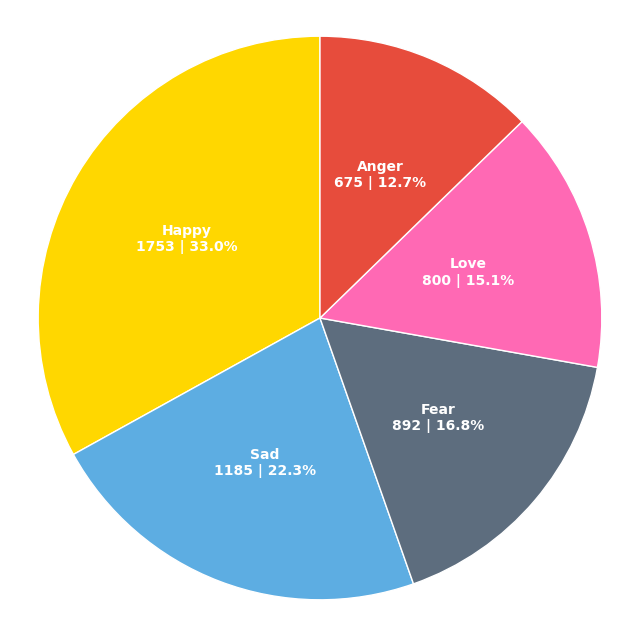

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ubah label 'Sadness' menjadi 'Sad'
df['Emotion'] = df['Emotion'].replace({'Sadness': 'Sad'})

# Hitung distribusi label
label_counts = df['Emotion'].value_counts()
labels = label_counts.index.tolist()
counts = label_counts.values

# Warna sesuai psikologi emosi
emotion_colors = {
    'Anger': '#E74C3C',
    'Fear': '#5D6D7E',
    'Happy': '#FFD700',
    'Love': '#FF69B4',
    'Sad': '#5DADE2'
}

colors = [emotion_colors.get(label, '#CCCCCC') for label in labels]

# Render pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts = ax.pie(
    counts,
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)

# Tambahkan teks di dalam pie
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.deg2rad(angle)) * 0.55
    y = np.sin(np.deg2rad(angle)) * 0.55

    percent = (counts[i] / counts.sum()) * 100
    text = f"{labels[i]}\n{counts[i]} | {percent:.1f}%"

    ax.text(
        x, y, text,
        ha='center', va='center',
        fontsize=10, weight='bold',
        color='white'
    )

ax.axis('equal')
plt.show()

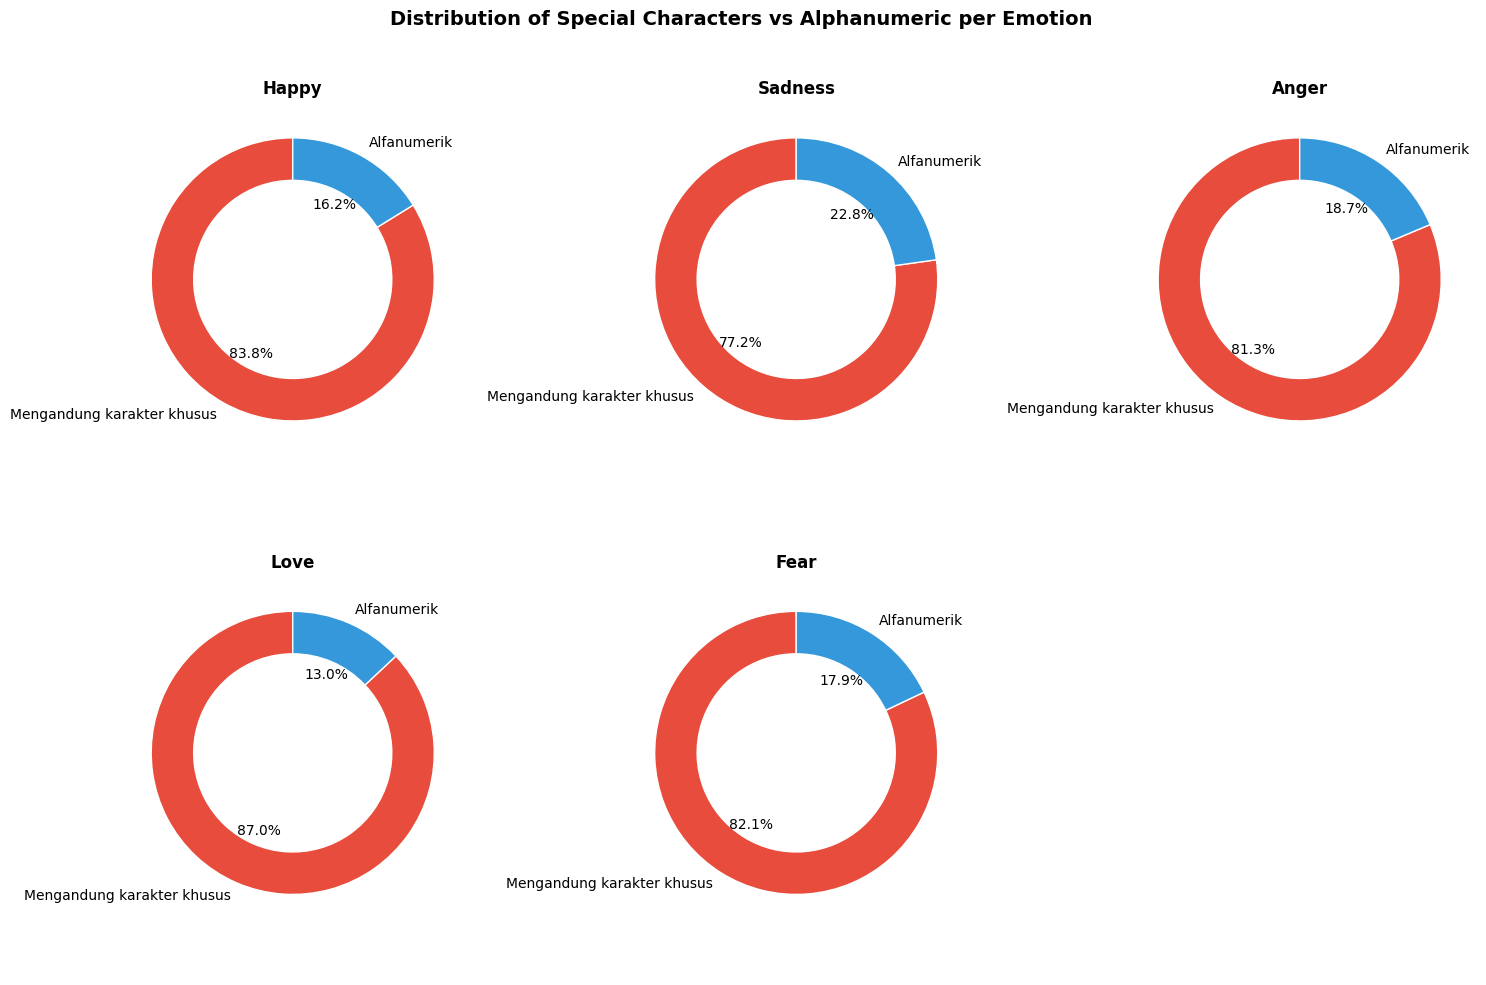

In [ ]:
import matplotlib.pyplot as plt
import re

# Fungsi untuk deteksi karakter khusus
def has_special_chars(text):
    return bool(re.search(r'[^a-zA-Z0-9\s]', str(text)))

# Warna dua kategori (merah & biru)
color_scheme = ['#E74C3C', '#3498DB']  # merah = karakter khusus, biru = alfanumerik

# Hitung distribusi karakter per emosi
def compute_distribution(df):
    results = {}
    for emotion in df['Emotion'].unique():
        subset = df[df['Emotion'] == emotion]['Customer Review']
        total = len(subset)
        special = subset.apply(has_special_chars).sum()
        alphanumeric = total - special
        results[emotion] = [special/total*100, alphanumeric/total*100]
    return results

# Hitung hasil distribusi
dist_emotions = compute_distribution(df)
labels_inner = ['Mengandung karakter khusus', 'Alfanumerik']

# Visualisasi pie chart per emosi
num_emotions = len(dist_emotions)
cols = 3
rows = (num_emotions + cols - 1) // cols  # atur jumlah baris otomatis

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, (emotion, dist) in enumerate(dist_emotions.items()):
    axes[i].pie(dist, labels=labels_inner, autopct='%1.1f%%',
                startangle=90, colors=color_scheme,
                wedgeprops={'width': 0.3, 'edgecolor': 'white'})
    axes[i].set_title(emotion, fontsize=12, fontweight='bold')

# Hilangkan axis kosong jika jumlah emosi < grid total
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribution of Special Characters vs Alphanumeric per Emotion',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# !pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
from tqdm import tqdm

# # === 1. Load kamus slang → formal ===
# slang_path = "/content/drive/MyDrive/Dataset Emotion Classification/colloquial-indonesian-lexicon.csv"
# slang_df = pd.read_csv(slang_path)

# # Buat dictionary: {slang: formal}
# slang_dict = dict(zip(slang_df["slang"], slang_df["formal"]))

# # === 2. Fungsi untuk normalisasi slang ===
# def normalize_slang(text):
#     words = text.split()
#     normalized_words = [slang_dict.get(w, w) for w in words]  # ganti jika ada di kamus
#     return " ".join(normalized_words)

# === 4. Fungsi preprocessing utama ===
def preprocess(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # 1. Lowercase
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)

    # 2. Normalisasi slang
    # text = normalize_slang(text)

    # 5. Hilangkan spasi ekstra
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# === 5. Terapkan ke dataset dengan progress bar ===
tqdm.pandas(desc="Processing text")
df['text_clean'] = df['Customer Review'].progress_apply(preprocess)

Processing text: 100%|██████████| 5305/5305 [00:00<00:00, 101745.77it/s]


In [ ]:
df

Customer Review Emotion  \
0     Alhamdulillah berfungsi dengan baik. Packaging...   Happy   
1     barang bagus dan respon cepat, harga bersaing ...   Happy   
2     barang bagus, berfungsi dengan baik, seler ram...   Happy   
3     bagus sesuai harapan penjual nya juga ramah. t...   Happy   
4     Barang Bagus, pengemasan Aman, dapat Berfungsi...   Happy   
...                                                 ...     ...   
5300  Harga bersaing, barang sesuai pesanan. Saya na...    Love   
5301  Beli ini krn Anak & Istri mau liburan di Jakar...    Love   
5302  pengemasan barang baik, kondisi barang jg utuh...   Happy   
5303  Mungil tapi bekerja dng baik. Dan murahh terja...   Happy   
5304  Produk sesuai deskripsi, packing aman terlindu...    Love   

                                             text_clean  
0     alhamdulillah berfungsi dengan baik packaging ...  
1     barang bagus dan respon cepat harga bersaing d...  
2     barang bagus berfungsi dengan baik seler ramah...  
3     bagus sesuai harapan penjual nya juga ramah tr...  
4     barang bagus pengemasan aman dapat berfungsi d...  
...                                                 ...  
5300  harga bersaing barang sesuai pesanan saya namb...  
5301  beli ini krn anak istri mau liburan di jakarta...  
5302  pengemasan barang baik kondisi barang jg utuh ...  
5303  mungil tapi bekerja dng baik dan murahh terjan...  
5304  produk sesuai deskripsi packing aman terlindun...  

[5305 rows x 3 columns]

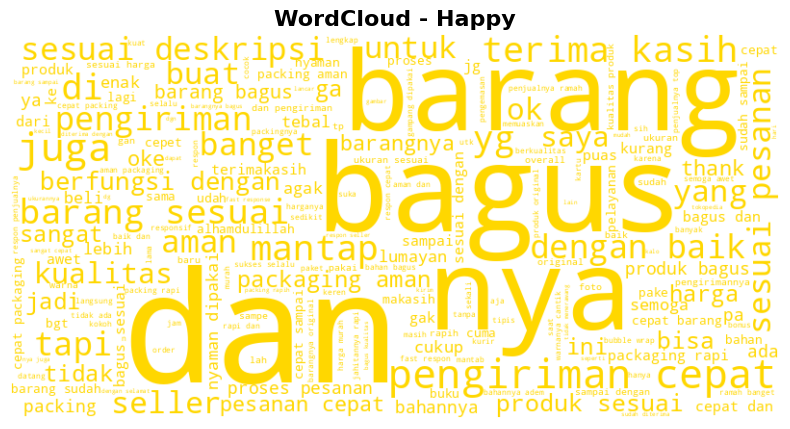

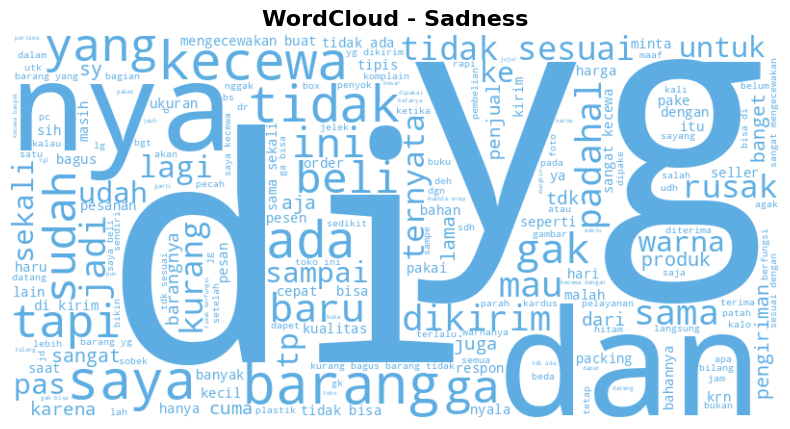

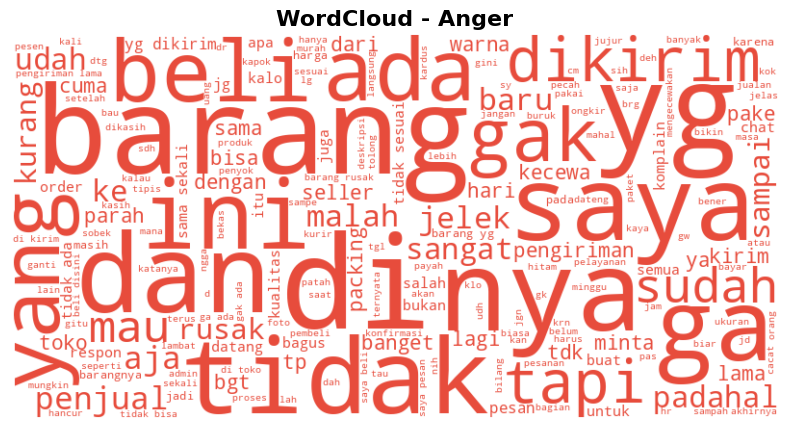

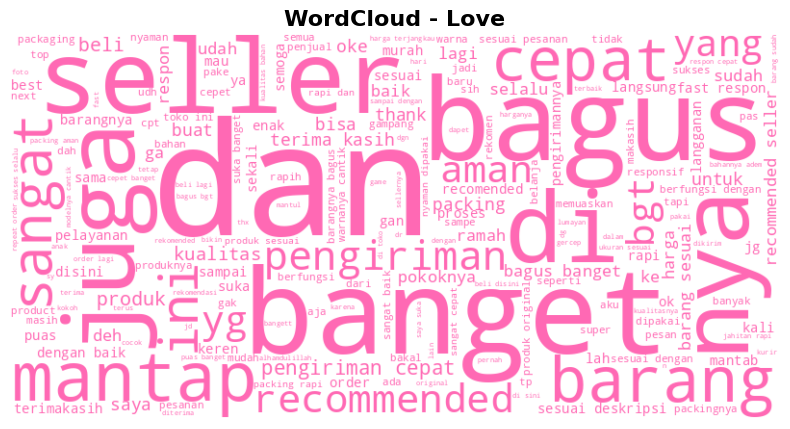

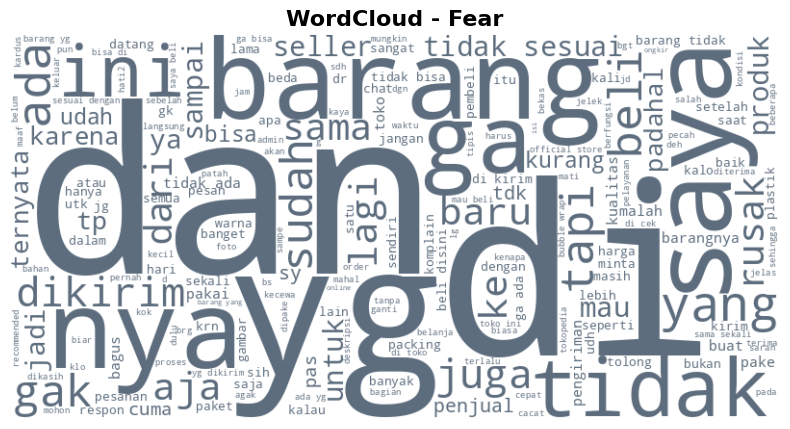

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Warna psikologi untuk setiap emosi
emotion_colors = {
    'Anger': '#E74C3C',     # merah → marah
    'Fear': '#5D6D7E',      # abu gelap → takut
    'Happy': '#FFD700',      # kuning → bahagia
    'Love': '#FF69B4',      # merah muda → kasih
    'Sadness': '#5DADE2'       # biru → sedih
}

for emotion in df['Emotion'].unique():
    text = ' '.join(df[df['Emotion'] == emotion]['text_clean'])

    # Fungsi untuk memberi warna tetap sesuai emotion
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return emotion_colors.get(emotion, '#000000')

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        color_func=color_func
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud - {emotion}', fontsize=16, fontweight='bold')
    plt.show()

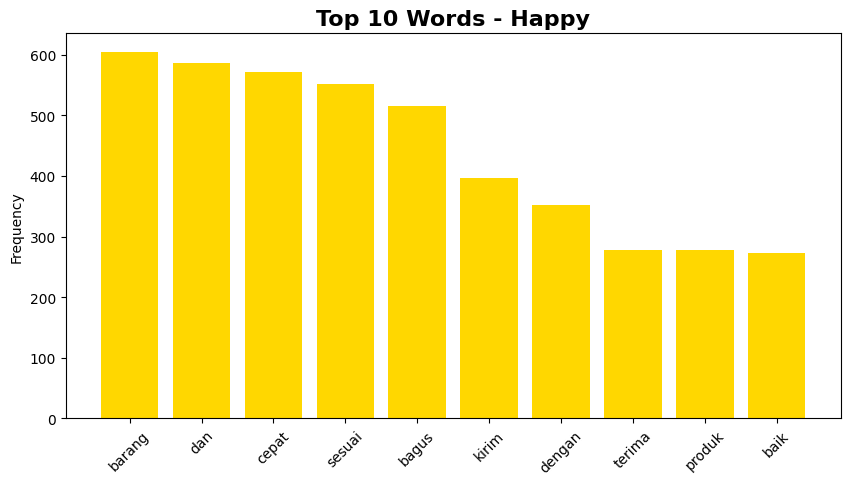

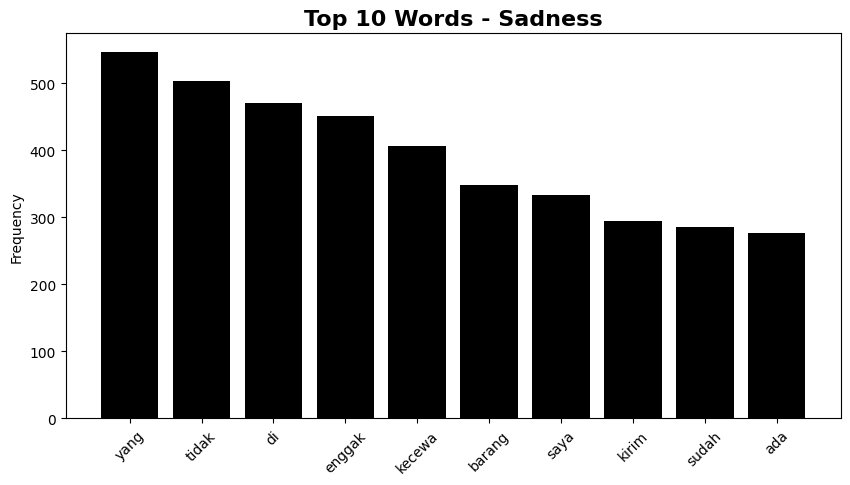

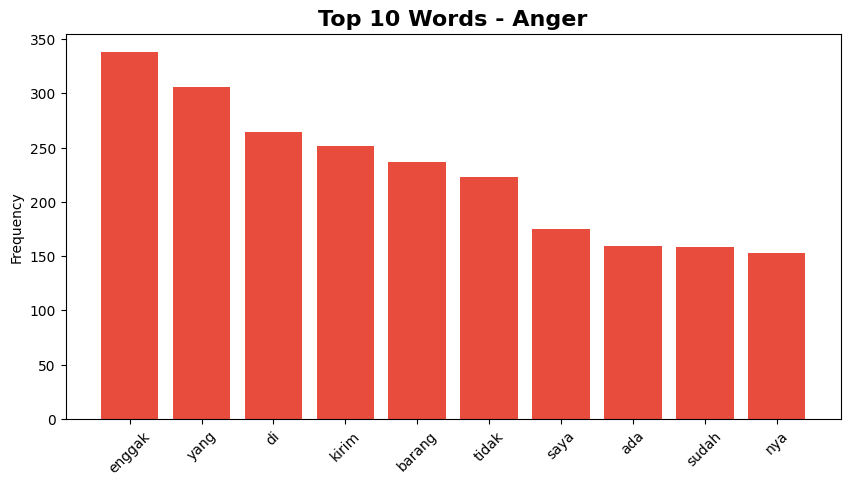

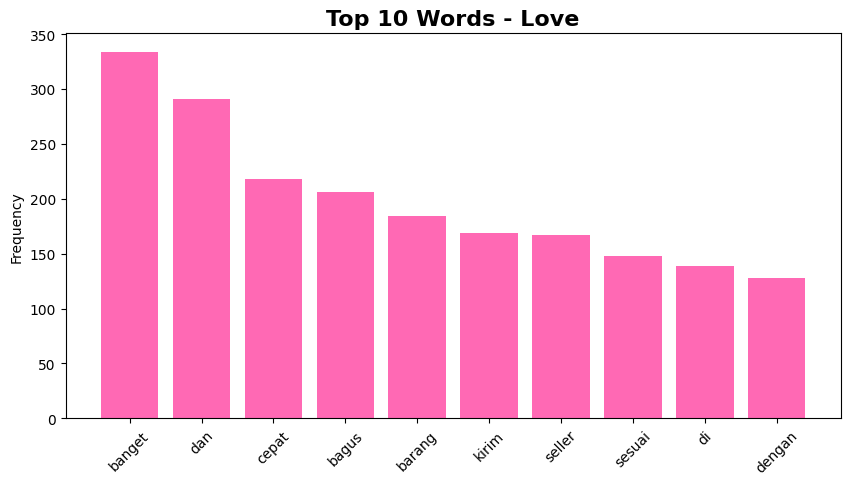

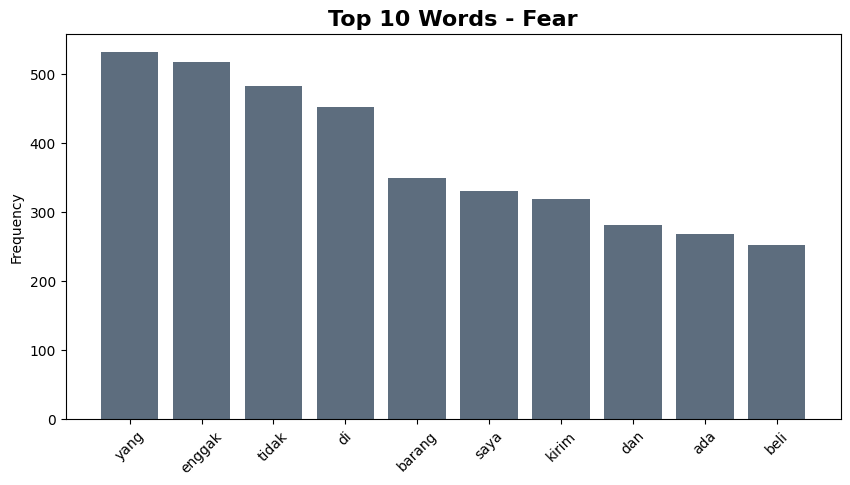

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Warna psikologi untuk setiap emosi
emotion_colors = {
    'Anger': '#E74C3C',     # merah → marah
    'Fear': '#5D6D7E',      # abu gelap → takut
    'Happy': '#FFD700',      # kuning → bahagia
    'Love': '#FF69B4',      # merah muda → kasih
    'Sad': '#5DADE2'       # biru → sedih
}

for emotion in df['Emotion'].unique():
    # Gabungkan semua teks untuk satu emosi
    text = ' '.join(df[df['Emotion'] == emotion]['text_clean'])

    # Hitung frekuensi kata
    words = text.split()
    word_counts = Counter(words)

    # Ambil top 10 kata
    top_words = word_counts.most_common(10)
    words, counts = zip(*top_words)

    # Plot bar chart
    plt.figure(figsize=(10,5))
    plt.bar(words, counts, color=emotion_colors.get(emotion, '#000000'))
    plt.title(f'Top 10 Words - {emotion}', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.show()

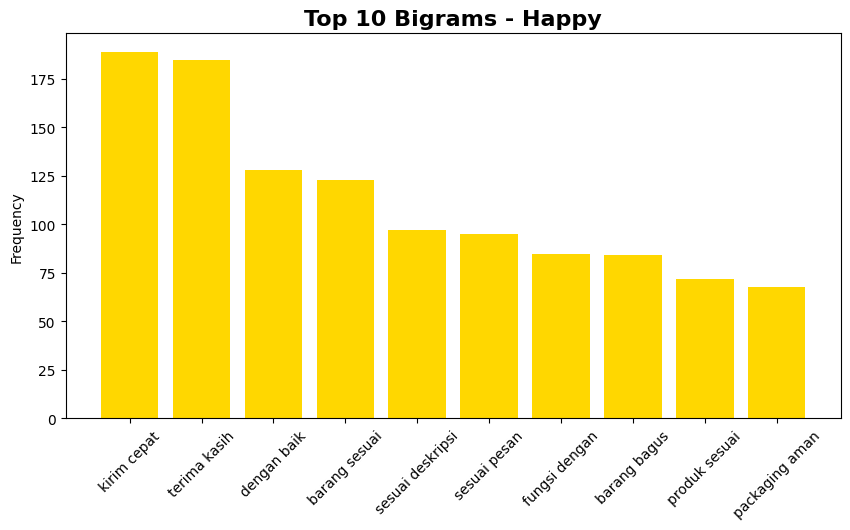

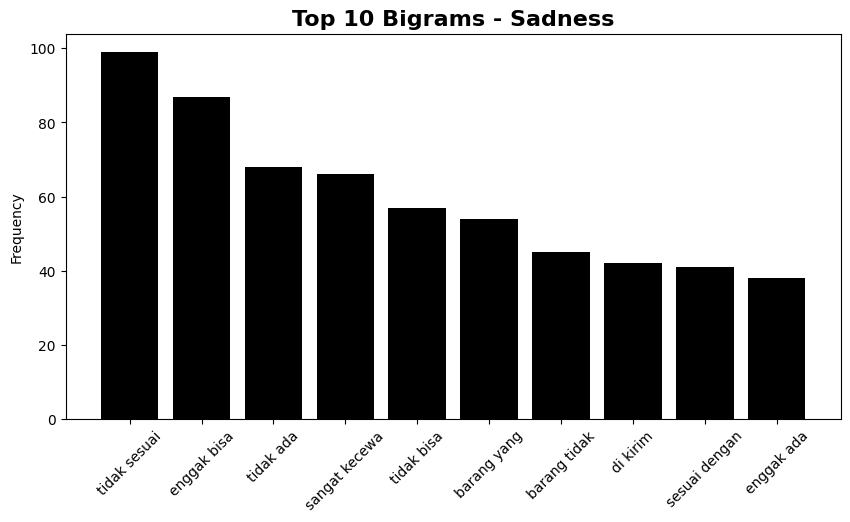

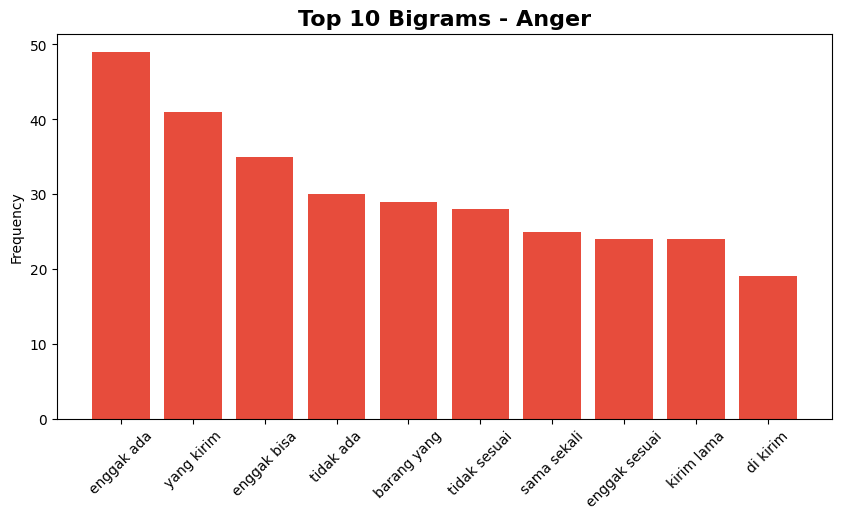

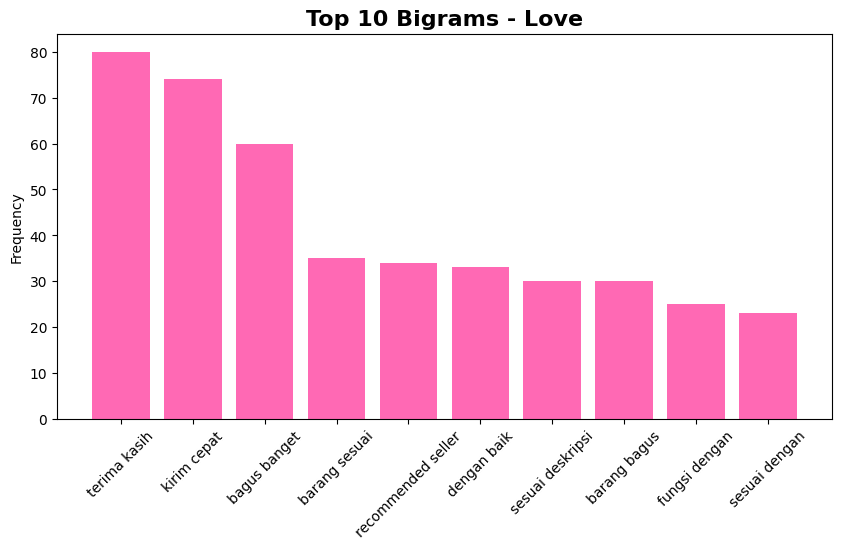

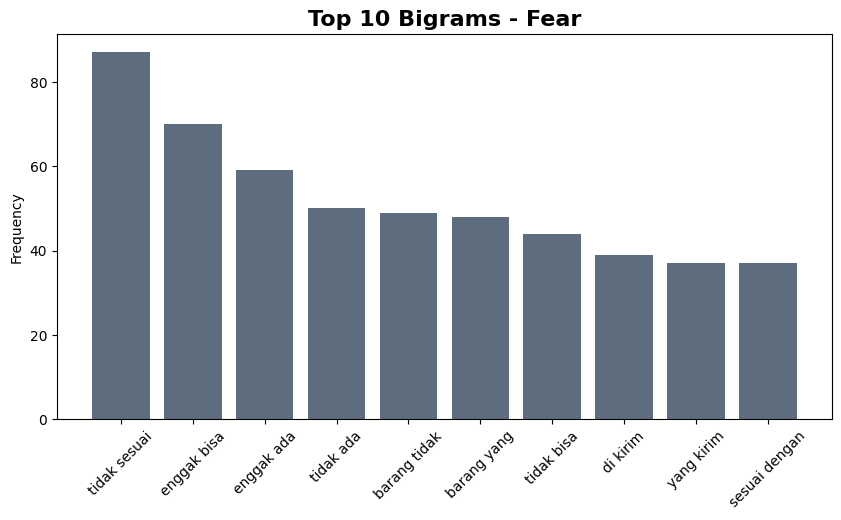

In [ ]:
from collections import Counter
from nltk import ngrams
import matplotlib.pyplot as plt

# Warna psikologi untuk setiap emosi
emotion_colors = {
    'Anger': '#E74C3C',     # merah → marah
    'Fear': '#5D6D7E',      # abu gelap → takut
    'Happy': '#FFD700',      # kuning → bahagia
    'Love': '#FF69B4',      # merah muda → kasih
    'Sad': '#5DADE2'      # biru → sedih
}

for emotion in df['Emotion'].unique():
    # Gabungkan semua teks untuk satu emosi
    text = ' '.join(df[df['Emotion'] == emotion]['text_clean'])

    # Tokenisasi
    words = text.split()

    # Buat bigram
    bigrams = ngrams(words, 2)

    # Hitung frekuensi bigram
    bigram_counts = Counter(bigrams)

    # Ambil top 10 bigram
    top_bigrams = bigram_counts.most_common(10)
    bigram_labels = [' '.join(b) for b, _ in top_bigrams]
    counts = [count for _, count in top_bigrams]

    # Plot bar chart
    plt.figure(figsize=(10,5))
    plt.bar(bigram_labels, counts, color=emotion_colors.get(emotion, '#000000'))
    plt.title(f'Top 10 Bigrams - {emotion}', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.show()

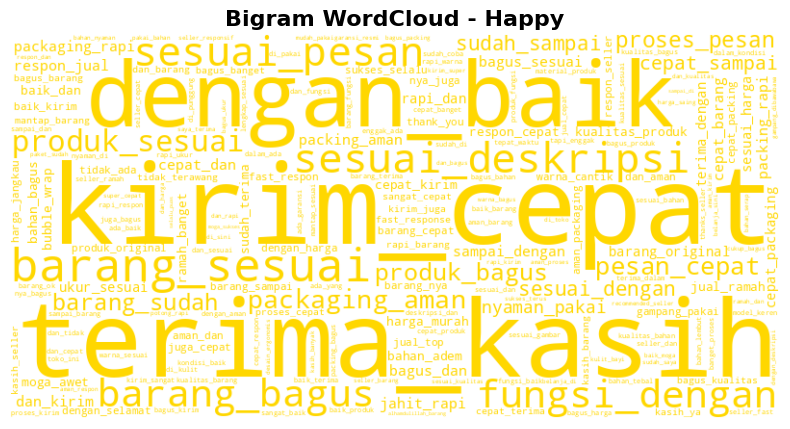

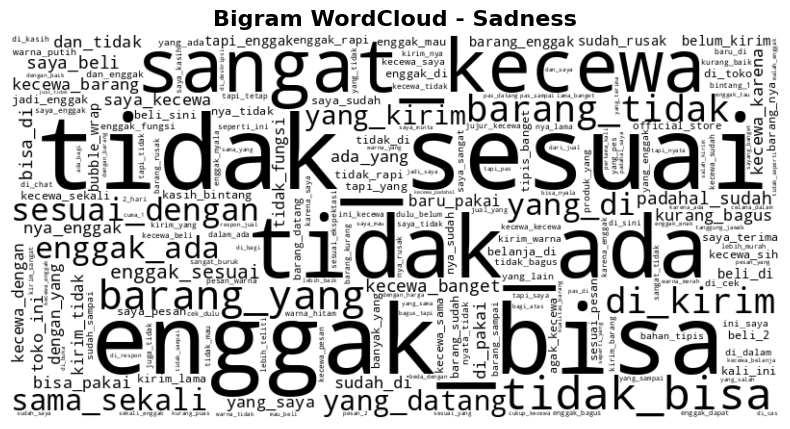

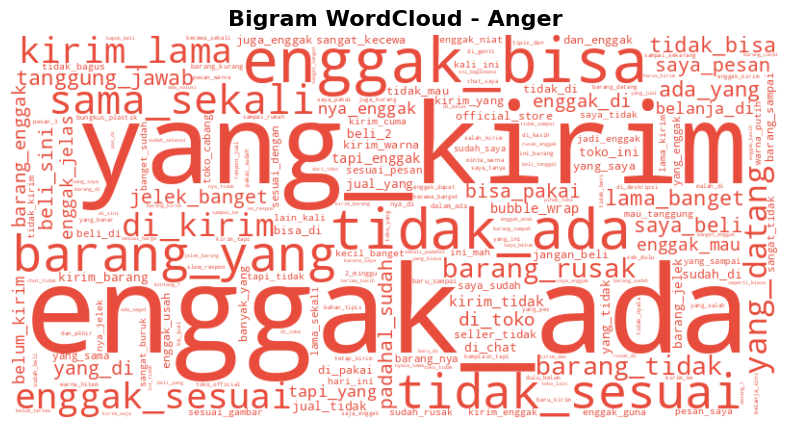

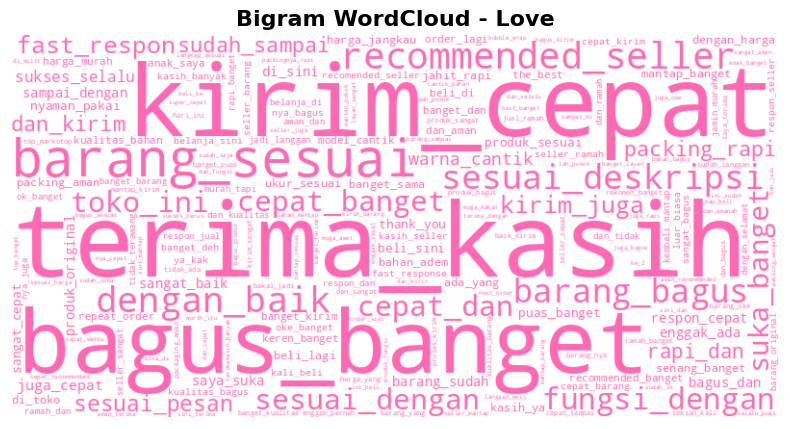

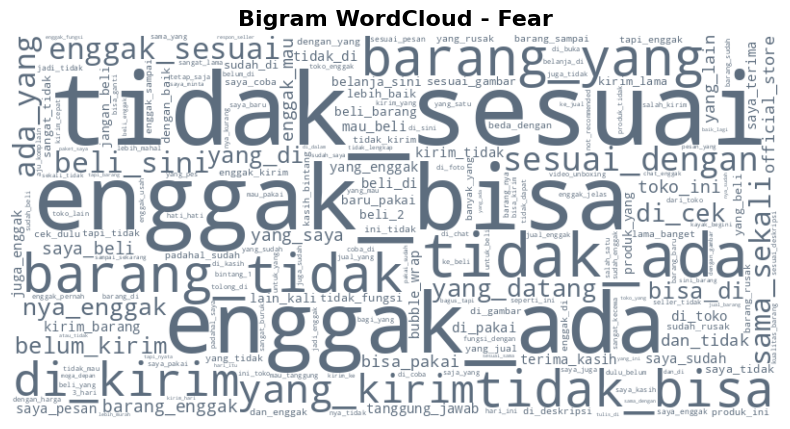

In [ ]:
from collections import Counter
from nltk import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Warna psikologi untuk setiap emosi
emotion_colors = {
    'Anger': '#E74C3C',     # merah → marah
    'Fear': '#5D6D7E',      # abu gelap → takut
    'Happy': '#FFD700',      # kuning → bahagia
    'Love': '#FF69B4',      # merah muda → kasih
    'Sad': '#5DADE2'       # biru → sedih
}

for emotion in df['Emotion'].unique():
    # Gabungkan semua teks untuk satu emosi
    text = ' '.join(df[df['Emotion'] == emotion]['text_clean'])

    # Tokenisasi dan buat bigram
    words = text.split()
    bigrams = ngrams(words, 2)

    # Ubah bigram menjadi string "kata1_kata2"
    bigram_strings = ['_'.join(b) for b in bigrams]

    # Hitung frekuensi bigram
    bigram_counts = Counter(bigram_strings)

    # Fungsi untuk memberi warna tetap sesuai emotion
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return emotion_colors.get(emotion, '#000000')

    # Generate WordCloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        color_func=color_func
    ).generate_from_frequencies(bigram_counts)

    # Tampilkan
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Bigram WordCloud - {emotion}', fontsize=16, fontweight='bold')
    plt.show()

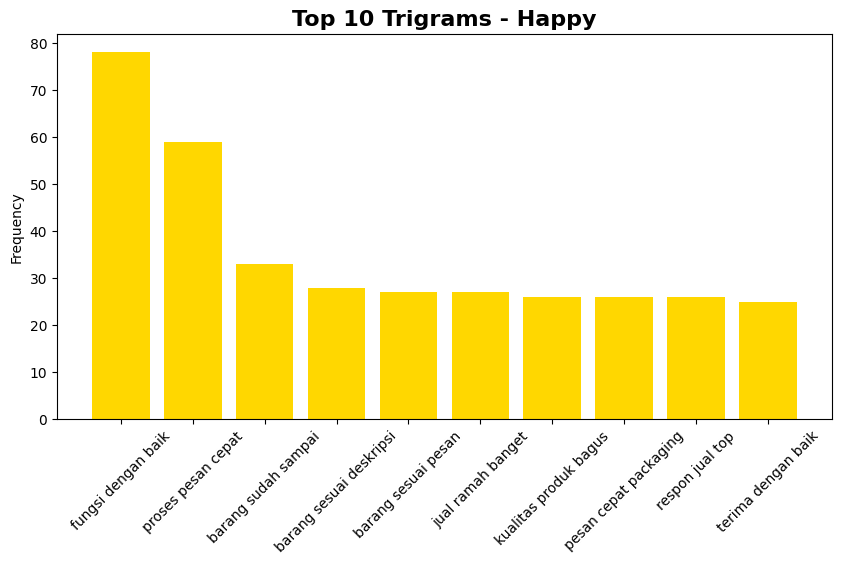

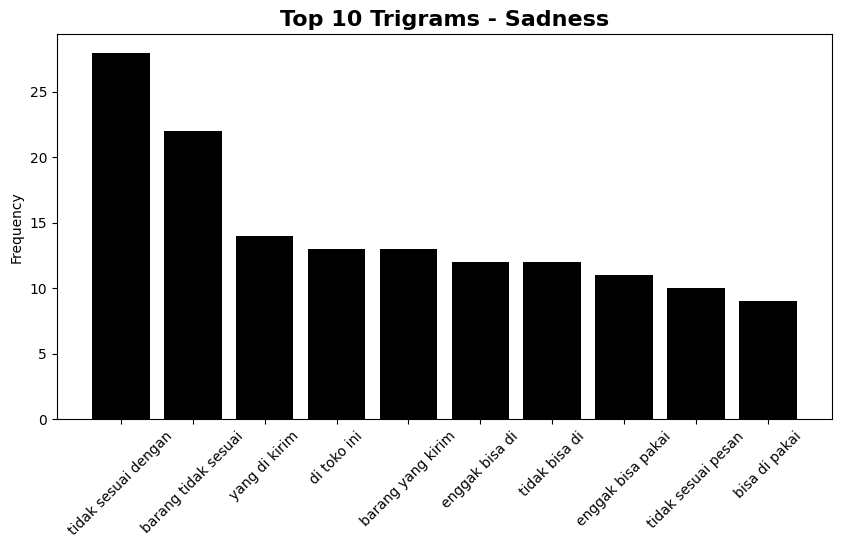

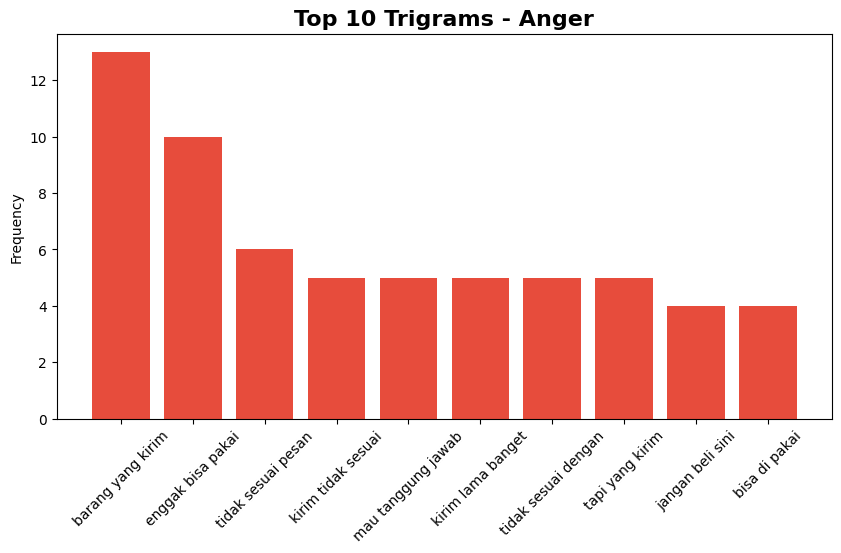

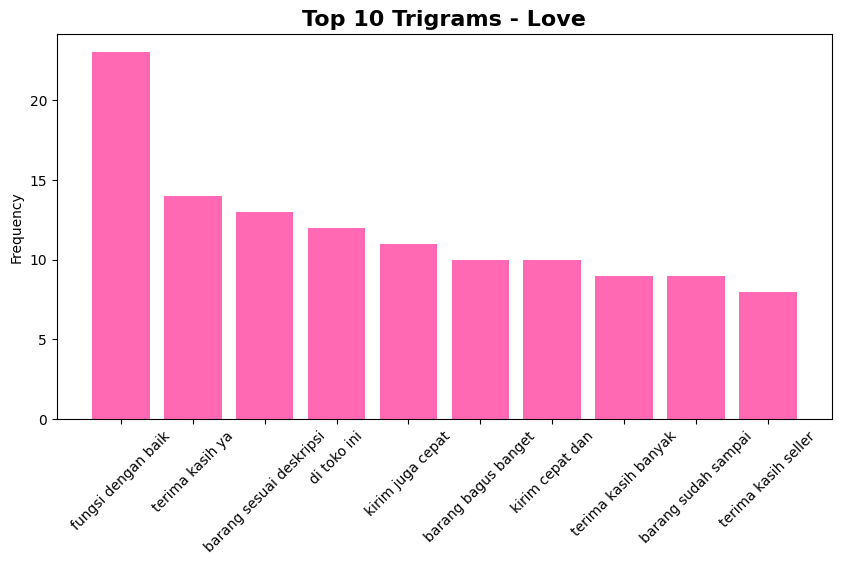

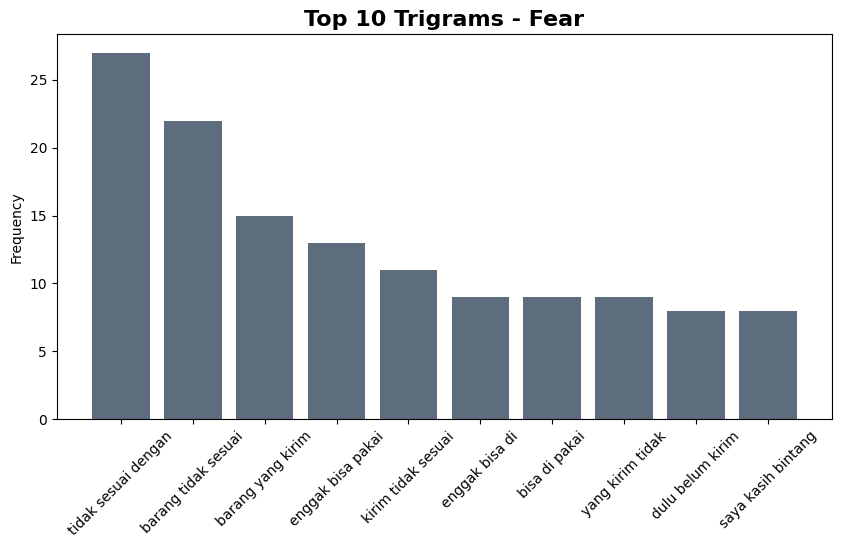

In [ ]:
from collections import Counter
from nltk import ngrams
import matplotlib.pyplot as plt

# Warna psikologi untuk setiap emosi
emotion_colors = {
    'Anger': '#E74C3C',
    'Fear': '#5D6D7E',
    'Happy': '#FFD700',
    'Love': '#FF69B4',
    'Sad': '#5DADE2'
}

for emotion in df['Emotion'].unique():
    # Gabungkan semua teks untuk satu emosi
    text = ' '.join(df[df['Emotion'] == emotion]['text_clean'])

    # Tokenisasi
    words = text.split()

    # Buat trigram
    trigrams = ngrams(words, 3)

    # Hitung frekuensi trigram
    trigram_counts = Counter(trigrams)

    # Ambil top 10 trigram
    top_trigrams = trigram_counts.most_common(10)
    trigram_labels = [' '.join(t) for t, _ in top_trigrams]
    counts = [count for _, count in top_trigrams]

    # Plot bar chart
    plt.figure(figsize=(10,5))
    plt.bar(trigram_labels, counts, color=emotion_colors.get(emotion, '#000000'))
    plt.title(f'Top 10 Trigrams - {emotion}', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.show()

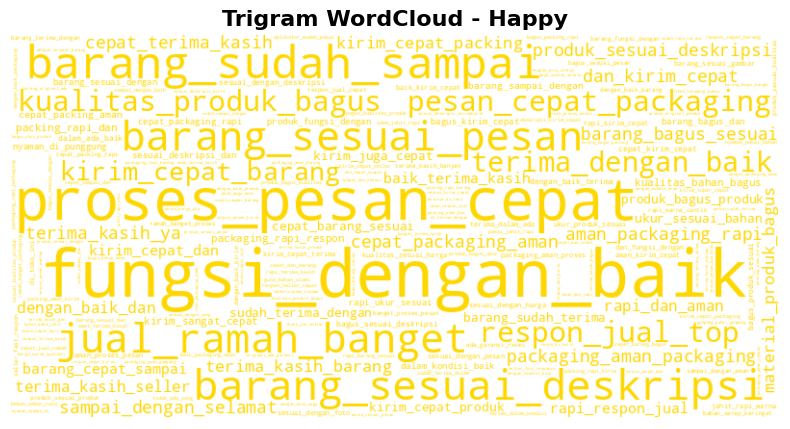

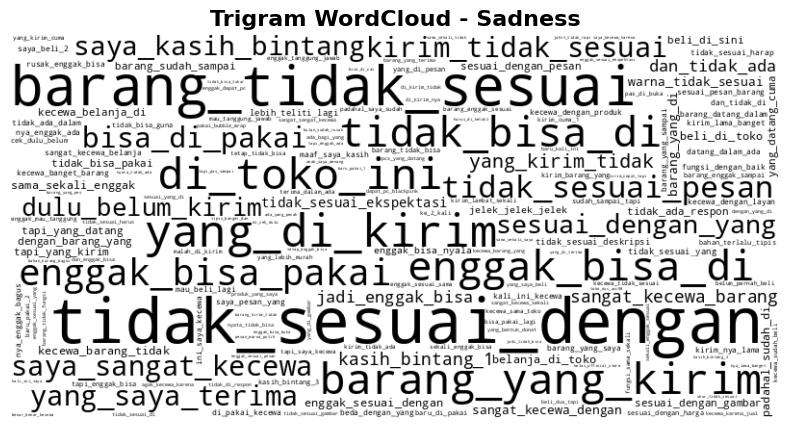

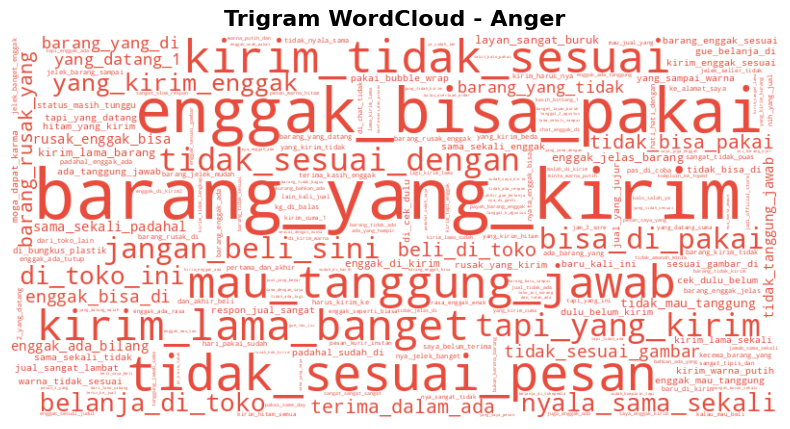

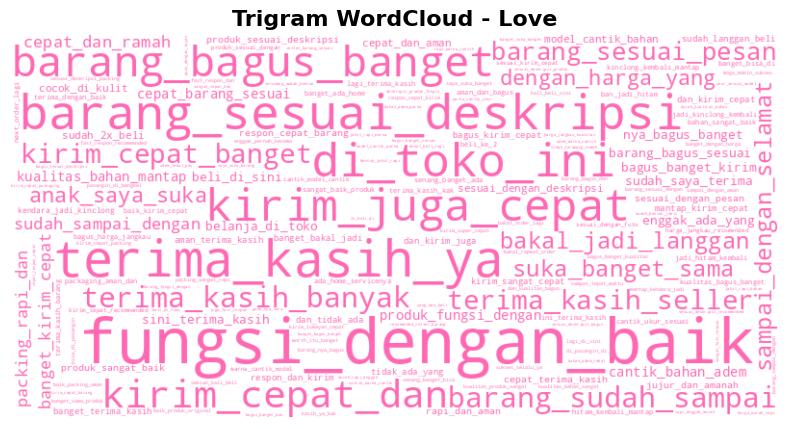

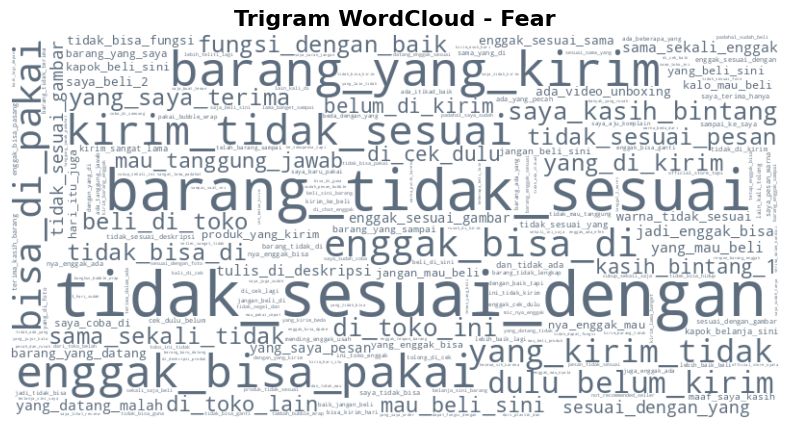

In [ ]:
from collections import Counter
from nltk import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for emotion in df['Emotion'].unique():
    # Gabungkan semua teks untuk satu emosi
    text = ' '.join(df[df['Emotion'] == emotion]['text_clean'])

    # Tokenisasi dan buat trigram
    words = text.split()
    trigrams = ngrams(words, 3)

    # Ubah trigram menjadi string "kata1_kata2_kata3"
    trigram_strings = ['_'.join(t) for t in trigrams]

    # Hitung frekuensi trigram
    trigram_counts = Counter(trigram_strings)

    # Fungsi untuk memberi warna tetap sesuai emotion
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return emotion_colors.get(emotion, '#000000')

    # Generate WordCloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        color_func=color_func
    ).generate_from_frequencies(trigram_counts)

    # Tampilkan
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Trigram WordCloud - {emotion}', fontsize=16, fontweight='bold')
    plt.show()

In [ ]:
import pandas as pd
import re

def contoh_text(df, emotion, keyword, n=5):
    """
    Menampilkan contoh kolom 'content' berdasarkan Emotion & kata kunci,
    tetapi pencocokan dilakukan di kolom 'text_clean'.
    """
    pattern = r'\b' + re.escape(keyword) + r'\b'
    subset = df[
        (df['Emotion'] == emotion) &
        (df['text_clean'].str.contains(pattern, regex=True, case=False))
    ]
    return subset['Customer Review'].head(n).tolist()  # ubah ke kolom 'content' saat ditampilkan

# ====== Contoh Penggunaan ======
kategori = {
    "Sadness": ["enggak", "kecewa", "padahal", "malah", "kurang"],
    "Fear": ["enggak", "tapi", "belum", "datang", "ada", "sesuai"],
    "Happy": ["mantap", "bagus", "sesuai"],
    "Love": ["bangat", "recommended", "mantap", "bagus"],
    "Anger": ["enggak", "tipu", "jelek", "sampah", "rusak"]
}

for emo, words in kategori.items():
    print(f"\n=== 🟦 Emotion: {emo.upper()} ===")
    for w in words:
        print(f"\n🔹 Kata: {w}")
        samples = contoh_text(df, emo, w)
        if len(samples) == 0:
            print("(tidak ditemukan contoh cocok)")
        else:
            for s in samples:
                print("-", s)


=== 🟦 Emotion: SADNESS ===

🔹 Kata: enggak
- jelek, yg pasti jauh dari ori. mousepad jd ga bs dipakai kl di charger, jd getar parah. barang ga sesui foto, kayak barang lapak sebelah yg harga 80rban. padahal sebelumnya pernah beli disini dan bagus,persis spt foto yg ada indikator di ujung charger. makanya order disini lg walaupun sedikit mahal ternyata barangnya tdk sama dgn order sebelumnya
- gak bisa di pakai??
- Kecewa parah nggk berkah jualan gitu
- kecewa penjual ga tanggung jawab komplen berhari� gada solusi
- pas beli nanya dulu tipe untuk macbook pro 13inch M1 yang mana di variasi nya, kata penjualnya yang �new pro 13�. pas dateng casing kekecilan karena salah tipe ternyata. dan penjual pake banyak alesan gamau tanggung jawab padahal yang salah ya yg ngejual. kecewa gamau lagi beli disini ga tanggung jawab.

🔹 Kata: kecewa
- Sangat kecewa. Baru 4 bulan scroll sudah rusak.
- Kecewa parah nggk berkah jualan gitu
- kecewa penjual ga tanggung jawab komplen berhari� gada solusi
- pa

In [ ]:
# Tentukan path file
output_path = '/content/drive/MyDrive/Dataset Emotion Classification/processed_dataset (2).csv'

# Simpan dataframe ke CSV
df.to_csv(output_path, index=False)

print(f"File berhasil disimpan di: {output_path}")

File berhasil disimpan di: /content/drive/MyDrive/Dataset Emotion Classification/processed_dataset (2).csv


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset Emotion Classification/processed_dataset (2).csv')

# Data Augmentation

In [ ]:
def balance_dataset(df, save_path=None):
    import time
    import random
    from tqdm import tqdm
    import pandas as pd

    balanced_df = pd.DataFrame(columns=df.columns)

    try:
        # ===============================
        # 1. Cek jumlah awal per label
        # ===============================
        label_counts = df['Emotion'].value_counts()
        print("\n=== 📊 Jumlah Awal per Label ===")
        print(label_counts)

        # Ambil jumlah terbesar sebagai target
        max_count = label_counts.max()
        print(f"\n🎯 Target per label = {max_count} (jumlah label terbanyak)\n")

        # ===============================
        # 2. Iterasi setiap label
        # ===============================
        for label, count in label_counts.items():
            subset = df[df['Emotion'] == label]
            texts = subset['text_clean'].tolist()

            # ---------------------------------------
            # CASE 1 — jumlah == max_count → aman
            # ---------------------------------------
            if count == max_count:
                balanced_df = pd.concat([balanced_df, subset], ignore_index=True)
                print(f"✅ {label}: jumlah {count} (sudah maksimal, tidak diubah)")
                continue

            # ---------------------------------------
            # CASE 2 — jumlah < max_count → augmentasi
            # ---------------------------------------
            print(f"\n🌀 Augmentasi label '{label}' ({count} → {max_count})")

            target_needed = max_count - count
            augmented = []

            # ================
            # 2A. Back Translation
            # ================
            for t in tqdm(texts, desc=f"BT {label}"):
                if len(augmented) >= target_needed:
                    break

                bt_text = back_translation(t, loops=1)
                if bt_text and bt_text != t:
                    augmented.append(bt_text)

                if len(augmented) >= target_needed:
                    break

                time.sleep(0.2)

            # ================
            # 2B. Synonym Replacement (jika masih kurang)
            # ================
            current_total = count + len(augmented)

            while current_total < max_count:
                needed = max_count - current_total
                print(f"🪄 SR untuk {label} (butuh {needed} lagi)")

                sample_texts = random.sample(texts, min(needed, len(texts)))

                for t in tqdm(sample_texts, desc=f"SR {label}"):
                    if current_total >= max_count:
                        break

                    sr_results = synonym_replacement(t, loops=1)
                    for sr in sr_results:
                        if sr != t:
                            augmented.append(sr)
                            current_total += 1
                        if current_total >= max_count:
                            break

            # Buat dataframe augmentasi
            aug_df = pd.DataFrame({
                "text_clean": augmented[:max_count - count],
                "Emotion": [label] * (max_count - count)
            })

            # Gabungkan data asli + augmentasi
            balanced_df = pd.concat([balanced_df, subset, aug_df], ignore_index=True)

            print(f"✅ {label} selesai → total: {count} asli + {len(aug_df)} augmentasi = {max_count}")

        # ===============================
        # 3. Jumlah akhir
        # ===============================
        print("\n=== 🎉 Jumlah Akhir per Label ===")
        print(balanced_df['Emotion'].value_counts())

    except Exception as e:
        print(f"\n⚠️ Error: {e}")

        if save_path:
            balanced_df.to_csv(save_path, index=False, encoding="utf-8-sig")
            print(f"💾 Disimpan sebelum error ke: {save_path}")

        raise e

    # ===============================
    # 4. Save hasil final
    # ===============================
    if save_path:
        balanced_df.to_csv(save_path, index=False, encoding="utf-8-sig")
        print(f"\n💾 File final disimpan ke: {save_path}")

    return balanced_df

In [ ]:
# ==================================================
# 🧩 Contoh penggunaan
# ==================================================
# Load dataset asli

import os

# Tentukan path output (folder sama dengan dict.json)
output_path = os.path.join(os.path.dirname(dict_path), "df_balanced (2).csv")

# Jalankan balancing dan simpan hasil
balanced_train_df = balance_dataset(df, save_path=output_path)


=== 📊 Jumlah Awal per Label ===
Emotion
Happy      1753
Sadness    1185
Fear        892
Love        800
Anger       675
Name: count, dtype: int64

🎯 Target per label = 1753 (jumlah label terbanyak)

✅ Happy: jumlah 1753 (sudah maksimal, tidak diubah)

🌀 Augmentasi label 'Sadness' (1185 → 1753)


BT Sadness:  50%|████▉     | 589/1185 [32:42<33:06,  3.33s/it]


✅ Sadness selesai → total: 1185 asli + 568 augmentasi = 1753

🌀 Augmentasi label 'Fear' (892 → 1753)


BT Fear:  98%|█████████▊| 872/892 [48:25<01:06,  3.33s/it]


✅ Fear selesai → total: 892 asli + 861 augmentasi = 1753

🌀 Augmentasi label 'Love' (800 → 1753)


BT Love: 100%|██████████| 800/800 [41:05<00:00,  3.08s/it]


🪄 SR untuk Love (butuh 160 lagi)


SR Love: 100%|██████████| 160/160 [00:00<00:00, 43841.94it/s]


🪄 SR untuk Love (butuh 9 lagi)


SR Love: 100%|██████████| 9/9 [00:00<00:00, 26639.90it/s]


🪄 SR untuk Love (butuh 1 lagi)


SR Love: 100%|██████████| 1/1 [00:00<00:00, 9238.56it/s]


✅ Love selesai → total: 800 asli + 953 augmentasi = 1753

🌀 Augmentasi label 'Anger' (675 → 1753)


BT Anger: 100%|██████████| 675/675 [36:07<00:00,  3.21s/it]


🪄 SR untuk Anger (butuh 422 lagi)


SR Anger: 100%|██████████| 422/422 [00:00<00:00, 53257.00it/s]


🪄 SR untuk Anger (butuh 9 lagi)


SR Anger: 100%|██████████| 9/9 [00:00<00:00, 25873.02it/s]

✅ Anger selesai → total: 675 asli + 1078 augmentasi = 1753

=== 🎉 Jumlah Akhir per Label ===
Emotion
Happy      1753
Sadness    1753
Fear       1753
Love       1753
Anger      1753
Name: count, dtype: int64

💾 File final disimpan ke: /content/drive/MyDrive/Dataset Emotion Classification/df_balanced (2).csv


# Split Dataset

In [ ]:
df_balanced = pd.read_csv('/content/drive/MyDrive/Dataset Emotion Classification/df_balanced.csv')

In [ ]:
from sklearn.model_selection import train_test_split

# --- Step 1: Split Train 80% dan Temp 20% ---
train_df, temp_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced["Emotion"],
    random_state=42
)

# --- Step 2: Split Temp 20% menjadi Val 10% + Test 10% ---
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["Emotion"],
    random_state=42
)

print("============== DISTRIBUSI DATA ==============\n")

print("Train size:", len(train_df))
print(train_df['Emotion'].value_counts(), "\n")

print("Validation size:", len(val_df))
print(val_df['Emotion'].value_counts(), "\n")

print("Test size:", len(test_df))
print(test_df['Emotion'].value_counts(), "\n")

============== DISTRIBUSI DATA ==============

Train size: 7012
Emotion
Sadness    1403
Fear       1403
Anger      1402
Happy      1402
Love       1402
Name: count, dtype: int64 

Validation size: 876
Emotion
Happy      176
Sadness    175
Fear       175
Love       175
Anger      175
Name: count, dtype: int64 

Test size: 877
Emotion
Anger      176
Love       176
Fear       175
Sadness    175
Happy      175
Name: count, dtype: int64 



In [ ]:
save_path = "/content/drive/MyDrive/Dataset Emotion Classification/"

val_df.to_csv(save_path + "val (2).csv", index=False)
test_df.to_csv(save_path + "test (2).csv", index=False)

print("✅ File berhasil disimpan di folder:")
print(save_path)

✅ File berhasil disimpan di folder:
/content/drive/MyDrive/Dataset Emotion Classification/


In [ ]:
love_samples = train_df[train_df['Emotion'] == 'Love']['text_clean'].sample(20, random_state=42)
print(love_samples.tolist())

['nyaman untuk olah raga, harga kompetitif dijamin paling murah', 'terima kasih rekomendasi penjual', 'Rekomendasi banget, barang diterima sesuai gambar', 'pengiriman alegro dan packing sangat kemas walau hanya belanja 1 item saja rekom banget gaes', 'kiyowo suka banget sama koleksi bt21 nya thanks ubs pengiriman cepat dan packing aman', 'check ini nya gampang banget cuma kasih lihat saja invoice sama ktp next mau lah order voucher lagi di sini terima kasih', 'Pesan kemarin sore, hari ini sudah sampai, packing super aman, bubble wrap ganda, bagus, reviewnya akan saya edit saat mencobanya, terima kasih', 'barang bagus, sesuai deskripsi, banyak batu full filter, pemasangan mudah, semoga awet dan pengiriman cepat, recomended seller', 'bagus banget bahan lumayan teball suka padahal murahh tapi kualitas lumayan lah tapiii suka', 'Terima kasih, berfungsi dengan baik, produk nyaman, mudah digunakan, kemasan aman, bahan berkualitas tinggi, dijamin termurah', 'Kualitas suaranya bagus banget apa

In [ ]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Ambil data label 'Love'
love_texts = train_df[train_df['Emotion'] == 'Love']['text_clean'].tolist()

In [ ]:
def plot_ngram_wordcloud(texts, ngram_range=(1,1), title="WordCloud"):
    # Gunakan CountVectorizer untuk bikin n-gram
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')  # stop_words bisa disesuaikan
    X = vectorizer.fit_transform(texts)
    freqs = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

    # Buat WordCloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds')
    wc.generate_from_frequencies(freqs)

    # Tampilkan
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

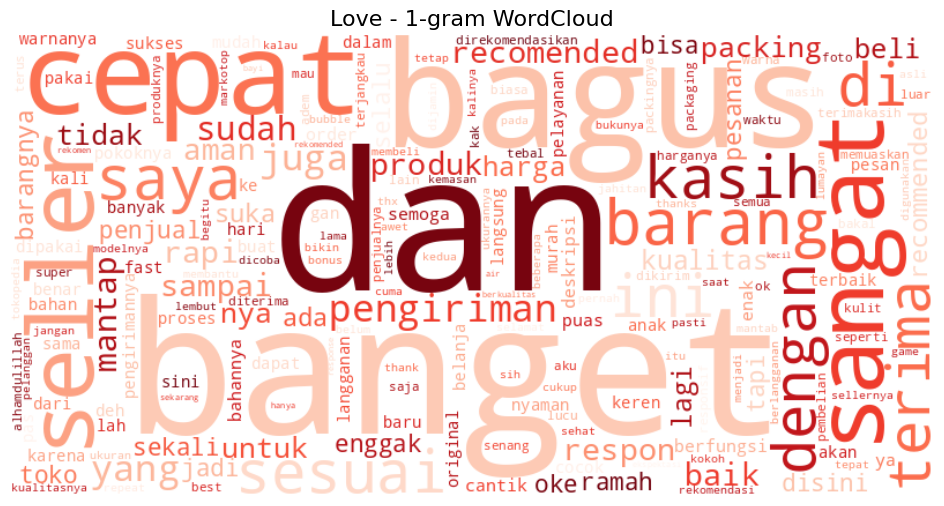

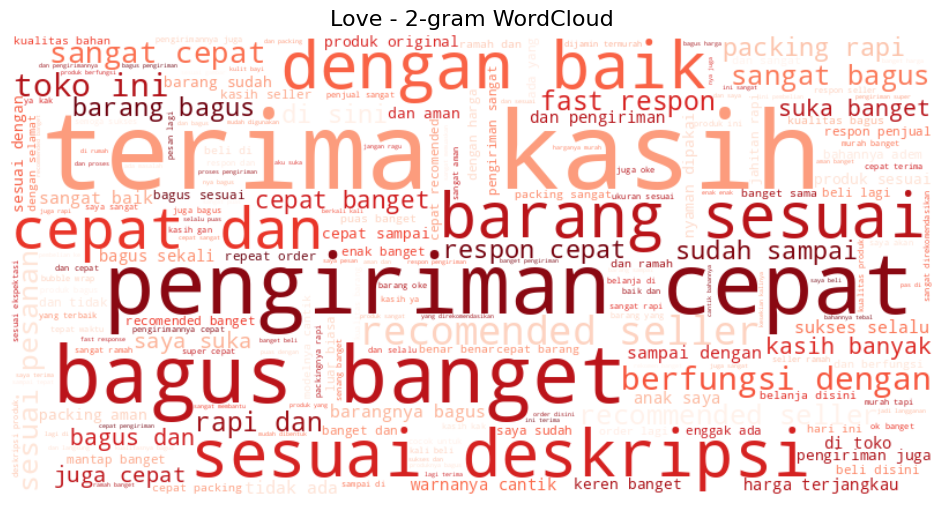

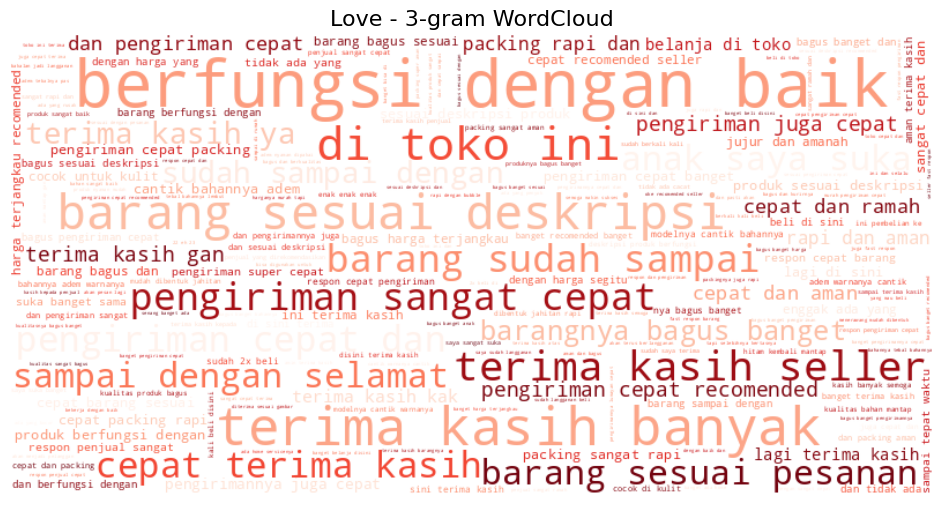

In [ ]:
# 1-gram
plot_ngram_wordcloud(love_texts, ngram_range=(1,1), title="Love - 1-gram WordCloud")

# 2-gram
plot_ngram_wordcloud(love_texts, ngram_range=(2,2), title="Love - 2-gram WordCloud")

# 3-gram
plot_ngram_wordcloud(love_texts, ngram_range=(3,3), title="Love - 3-gram WordCloud")

In [ ]:
import pandas as pd

test_df = pd.read_csv('/content/drive/MyDrive/Dataset Emotion Classification/test.csv')

In [ ]:
import pandas as pd

# --- Ambil 30 sample per label ---
labels = test_df['Emotion'].unique()
test_small = []

for label in labels:
    subset = test_df[test_df['Emotion'] == label]
    n = min(45, len(subset))  # ambil maksimal 30 atau sebanyak yang ada
    sampled = subset.sample(n=n, random_state=42)
    test_small.append(sampled)

# Gabungkan kembali
test_df_small = pd.concat(test_small).reset_index(drop=True)

# --- Cek hasil ---
print("Test size:", len(test_df_small))
print(test_df_small['Emotion'].value_counts())

# --- Simpan ke Google Drive ---
save_path = "/content/drive/MyDrive/Dataset Emotion Classification/test_llm (2).csv"
test_df_small.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"\n💾 Test set tersimpan ke: {save_path}")

Test size: 225
Emotion
Happy      45
Sadness    45
Fear       45
Love       45
Anger      45
Name: count, dtype: int64

💾 Test set tersimpan ke: /content/drive/MyDrive/Dataset Emotion Classification/test_llm (2).csv


# IndoBERT

In [ ]:
df_balanced_path = "/content/drive/MyDrive/Dataset Emotion Classification/df_balanced (2).csv"

In [ ]:
df_balanced = pd.read_csv(df_balanced_path)

In [ ]:
from sklearn.model_selection import train_test_split

# --- Step 1: Split Train 80% dan Temp 20% ---
train_df, temp_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced["Emotion"],
    random_state=42
)

# --- Step 2: Split Temp 20% menjadi Val 10% + Test 10% ---
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["Emotion"],
    random_state=42
)

print("============== DISTRIBUSI DATA ==============\n")

print("Train size:", len(train_df))
print(train_df['Emotion'].value_counts(), "\n")

print("Validation size:", len(val_df))
print(val_df['Emotion'].value_counts(), "\n")

print("Test size:", len(test_df))
print(test_df['Emotion'].value_counts(), "\n")

============== DISTRIBUSI DATA ==============

Train size: 7012
Emotion
Sadness    1403
Fear       1403
Anger      1402
Happy      1402
Love       1402
Name: count, dtype: int64 

Validation size: 876
Emotion
Happy      176
Sadness    175
Fear       175
Love       175
Anger      175
Name: count, dtype: int64 

Test size: 877
Emotion
Anger      176
Love       176
Fear       175
Sadness    175
Happy      175
Name: count, dtype: int64 



In [ ]:
val_df = val_df[["text_clean", "Emotion"]]

In [ ]:
val_df[val_df.duplicated(subset=["text_clean"])]

text_clean Emotion
6441     Bagus sekali    Love
7242  pengiriman lama   Anger

In [ ]:
val_df = val_df.drop_duplicates(subset=["text_clean"])

In [ ]:
val_df["Emotion"].value_counts()

Emotion
Happy      176
Sadness    175
Fear       175
Love       174
Anger      174
Name: count, dtype: int64

In [ ]:
train_df = train_df[["text_clean", "Emotion"]]

In [ ]:
train_df[train_df.duplicated(subset=["text_clean"])]

text_clean  Emotion
2142                                       mengecewakan  Sadness
7815       pengirimannya memakan waktu yang sangat lama    Anger
6722                                       sangat bagus     Love
4293                                       tidak sesuai     Fear
7679                                       mengecewakan    Anger
3692                      barang tidak sesuai deskripsi     Fear
596                                       barang sesuai    Happy
673          material produk bagus ukuran produk sesuai    Happy
373                                              mantap    Happy
3094                               tidak sesuai harapan  Sadness
6344                                       sangat bagus     Love
8229                             penjualnya tidak ramah    Anger
3183                               layanan mengecewakan  Sadness
1916                                       mengecewakan  Sadness
5766                     fast respon recommended seller     Love
1869                                             kecewa  Sadness
3328                                       tidak sesuai  Sadness
6118                                       sangat bagus     Love
406                                     produk original    Happy
7350                                    tidak berfungsi    Anger
5269                                            top bgt     Love
6440                                       barang padat     Love
6448                                       sangat bagus     Love
2042                             pengiriman sangat lama  Sadness
4826                      barangnya tidak sesuai gambar     Fear
3378                                bahannya tidak enak  Sadness
5929                                       bagus banget     Love
7194                                             kecewa    Anger
952                                    mantap barangnya    Happy
5418                                             mantap     Love
5644                                             mantap     Love
6439                      penjual yang direkomendasikan     Love
3123                                    tidak berfungsi  Sadness
160                                      sesuai pesanan    Happy
5268                                 recommended seller     Love
5920                                       bagus banget     Love
5446                                             mantap     Love
309                          barang sesuai terima kasih    Happy
3267                                      sangat kecewa  Sadness
934                               berfungsi dengan baik    Happy
6245                                       Bagus sekali     Love
6579                      penjual yang direkomendasikan     Love
8065                             pengiriman sangat lama    Anger
3462                             bahannya terlalu tipis  Sadness
4583                   barangnya tidak sesuai deskripsi     Fear
290                               barang sesuai pesanan    Happy
3249                                      sangat kecewa  Sadness
1075  barang sudah sampai pelayanan cepat sekali pac...    Happy
319                        produk berfungsi dengan baik    Happy
6402                                       Bagus sekali     Love
5085                             penjualnya tidak ramah     Fear

In [ ]:
train_df = train_df.drop_duplicates(subset=["text_clean"])

In [ ]:
train_df["Emotion"].value_counts()

Emotion
Fear       1398
Anger      1396
Happy      1391
Sadness    1391
Love       1385
Name: count, dtype: int64

In [ ]:
df_train = train_df
df_val = val_df

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, Dataset
import torch
import numpy as np
import evaluate

# 1. Tentukan Model dan Label
model_name = "indobenchmark/indobert-base-p1"
# Ganti dengan label emosi yang sebenarnya dari data Anda, contoh:
label_list = ["Happy", "Anger", "Sadness", "Love", "Fear"]
num_labels = len(label_list)

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["Emotion"])
df_val["label"] = le.transform(df_val["Emotion"])  # pakai transform, bukan fit_transform

In [ ]:
df_train[["Emotion", "label"]].drop_duplicates().sort_values("label")

Emotion  label
8562    Anger      0
3717     Fear      1
1010    Happy      2
6225     Love      3
3471  Sadness      4

In [ ]:
df_val[["Emotion", "label"]].drop_duplicates().sort_values("label")

Emotion  label
7940    Anger      0
4890     Fear      1
539     Happy      2
5687     Love      3
2282  Sadness      4

In [ ]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
label_map

{'Anger': np.int64(0),
 'Fear': np.int64(1),
 'Happy': np.int64(2),
 'Love': np.int64(3),
 'Sadness': np.int64(4)}

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(df_train[["text_clean", "label"]])
val_dataset = Dataset.from_pandas(df_val[["text_clean", "label"]])

In [ ]:
train_dataset = train_dataset.rename_column("text_clean", "text")
val_dataset = val_dataset.rename_column("text_clean", "text")

In [ ]:
def tokenize_function(examples):
    # Ensure sequences are padded to a uniform length and truncated if necessary
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

In [ ]:
# lengths = df_train["text_clean"].apply(lambda x: len(tokenizer.tokenize(x)))
# lengths.describe()

In [ ]:
tokenized_train_data = train_dataset.map(tokenize_function, batched=True)
tokenized_val_data = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6961 [00:00<?, ? examples/s]

Map:   0%|          | 0/874 [00:00<?, ? examples/s]

In [ ]:
cols_to_remove = ["text", "Emotion", "__index_level_0__"]

tokenized_train_data = tokenized_train_data.remove_columns(
    [c for c in cols_to_remove if c in tokenized_train_data.column_names]
)

tokenized_val_data = tokenized_val_data.remove_columns(
    [c for c in cols_to_remove if c in tokenized_val_data.column_names]
)

In [ ]:
from transformers import AutoModelForSequenceClassification
import numpy as np

In [ ]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1_macro = metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"f1": f1_macro}

In [ ]:
LEARNING_RATE = 2e-6 # Perlu diatur di TrainingArguments

In [ ]:
from transformers import EarlyStoppingCallback, TrainingArguments

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3
)

In [ ]:
training_args = TrainingArguments(
    output_dir="./finetuning_results", # Ganti nama output folder

    # Hyperparameters
    learning_rate=LEARNING_RATE, # Tetapkan Learning Rate default
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.3, # Tambahkan weight decay default jika tidak di-tune

    # Maks epoch + load model terbaik
    num_train_epochs=20,
    metric_for_best_model="f1",

    load_best_model_at_end=True,

    # Evaluasi dan penyimpanan
    save_strategy="epoch",
    eval_strategy="epoch",

    logging_dir='./finetuning_logs',
    logging_steps=100,
    report_to="none",
)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

DROPOUT_RATE = 0.1

def init_full_finetune_model():
    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=num_labels,
        hidden_dropout_prob=DROPOUT_RATE,
        attention_probs_dropout_prob=DROPOUT_RATE
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
    )

    return model

In [ ]:
from transformers import Trainer

final_model = init_full_finetune_model()

trainer = Trainer(
    model=final_model, # Gunakan model full fine-tuning
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

# 4. Latih Model
print("\n🔥 Memulai Pelatihan Full Fine-Tuning...")
trainer.train()

# 5. Evaluasi Hasil Akhir
print("\n✅ Evaluasi Akhir:")
final_results = trainer.evaluate()
print(final_results)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔥 Memulai Pelatihan Full Fine-Tuning...



✅ Evaluasi Akhir:


{'eval_loss': 0.8381384611129761, 'eval_f1': 0.7816001291899985, 'eval_runtime': 12.16, 'eval_samples_per_second': 71.875, 'eval_steps_per_second': 9.046, 'epoch': 14.0}


# DistilBERT

In [ ]:
df_balanced_path = "/content/drive/MyDrive/Dataset Emotion Classification/df_balanced (2).csv"

In [ ]:
df_balanced = pd.read_csv(df_balanced_path)

In [ ]:
from sklearn.model_selection import train_test_split

# --- Step 1: Split Train 80% dan Temp 20% ---
train_df, temp_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced["Emotion"],
    random_state=42
)

# --- Step 2: Split Temp 20% menjadi Val 10% + Test 10% ---
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["Emotion"],
    random_state=42
)

print("============== DISTRIBUSI DATA ==============\n")

print("Train size:", len(train_df))
print(train_df['Emotion'].value_counts(), "\n")

print("Validation size:", len(val_df))
print(val_df['Emotion'].value_counts(), "\n")

print("Test size:", len(test_df))
print(test_df['Emotion'].value_counts(), "\n")

============== DISTRIBUSI DATA ==============

Train size: 7012
Emotion
Sadness    1403
Fear       1403
Anger      1402
Happy      1402
Love       1402
Name: count, dtype: int64 

Validation size: 876
Emotion
Happy      176
Sadness    175
Fear       175
Love       175
Anger      175
Name: count, dtype: int64 

Test size: 877
Emotion
Anger      176
Love       176
Fear       175
Sadness    175
Happy      175
Name: count, dtype: int64 



In [ ]:
val_df = val_df[["text_clean", "Emotion"]]

In [ ]:
val_df[val_df.duplicated(subset=["text_clean"])]

text_clean Emotion
6441     Bagus sekali    Love
7242  pengiriman lama   Anger

In [ ]:
val_df = val_df.drop_duplicates(subset=["text_clean"])

In [ ]:
val_df["Emotion"].value_counts()

Emotion
Happy      176
Sadness    175
Fear       175
Love       174
Anger      174
Name: count, dtype: int64

In [ ]:
train_df = train_df[["text_clean", "Emotion"]]

In [ ]:
train_df[train_df.duplicated(subset=["text_clean"])]

text_clean  Emotion
2142                                       mengecewakan  Sadness
7815       pengirimannya memakan waktu yang sangat lama    Anger
6722                                       sangat bagus     Love
4293                                       tidak sesuai     Fear
7679                                       mengecewakan    Anger
3692                      barang tidak sesuai deskripsi     Fear
596                                       barang sesuai    Happy
673          material produk bagus ukuran produk sesuai    Happy
373                                              mantap    Happy
3094                               tidak sesuai harapan  Sadness
6344                                       sangat bagus     Love
8229                             penjualnya tidak ramah    Anger
3183                               layanan mengecewakan  Sadness
1916                                       mengecewakan  Sadness
5766                     fast respon recommended seller     Love
1869                                             kecewa  Sadness
3328                                       tidak sesuai  Sadness
6118                                       sangat bagus     Love
406                                     produk original    Happy
7350                                    tidak berfungsi    Anger
5269                                            top bgt     Love
6440                                       barang padat     Love
6448                                       sangat bagus     Love
2042                             pengiriman sangat lama  Sadness
4826                      barangnya tidak sesuai gambar     Fear
3378                                bahannya tidak enak  Sadness
5929                                       bagus banget     Love
7194                                             kecewa    Anger
952                                    mantap barangnya    Happy
5418                                             mantap     Love
5644                                             mantap     Love
6439                      penjual yang direkomendasikan     Love
3123                                    tidak berfungsi  Sadness
160                                      sesuai pesanan    Happy
5268                                 recommended seller     Love
5920                                       bagus banget     Love
5446                                             mantap     Love
309                          barang sesuai terima kasih    Happy
3267                                      sangat kecewa  Sadness
934                               berfungsi dengan baik    Happy
6245                                       Bagus sekali     Love
6579                      penjual yang direkomendasikan     Love
8065                             pengiriman sangat lama    Anger
3462                             bahannya terlalu tipis  Sadness
4583                   barangnya tidak sesuai deskripsi     Fear
290                               barang sesuai pesanan    Happy
3249                                      sangat kecewa  Sadness
1075  barang sudah sampai pelayanan cepat sekali pac...    Happy
319                        produk berfungsi dengan baik    Happy
6402                                       Bagus sekali     Love
5085                             penjualnya tidak ramah     Fear

In [ ]:
train_df = train_df.drop_duplicates(subset=["text_clean"])

In [ ]:
train_df["Emotion"].value_counts()

Emotion
Fear       1398
Anger      1396
Happy      1391
Sadness    1391
Love       1385
Name: count, dtype: int64

In [ ]:
df_train = train_df
df_val = val_df

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, Dataset
import torch
import numpy as np
import evaluate

# 1. Tentukan Model dan Label
model_name = "cahya/distilbert-base-indonesian"
# Ganti dengan label emosi yang sebenarnya dari data Anda, contoh:
label_list = ["Happy", "Anger", "Sadness", "Love", "Fear"]
num_labels = len(label_list)

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["Emotion"])
df_val["label"] = le.transform(df_val["Emotion"])  # pakai transform, bukan fit_transform

In [ ]:
df_train[["Emotion", "label"]].drop_duplicates().sort_values("label")

Emotion  label
8562    Anger      0
3717     Fear      1
1010    Happy      2
6225     Love      3
3471  Sadness      4

In [ ]:
df_val[["Emotion", "label"]].drop_duplicates().sort_values("label")

Emotion  label
7940    Anger      0
4890     Fear      1
539     Happy      2
5687     Love      3
2282  Sadness      4

In [ ]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
label_map

{'Anger': np.int64(0),
 'Fear': np.int64(1),
 'Happy': np.int64(2),
 'Love': np.int64(3),
 'Sadness': np.int64(4)}

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(df_train[["text_clean", "label"]])
val_dataset = Dataset.from_pandas(df_val[["text_clean", "label"]])

In [ ]:
train_dataset = train_dataset.rename_column("text_clean", "text")
val_dataset = val_dataset.rename_column("text_clean", "text")

In [ ]:
def tokenize_function(examples):
    # Ensure sequences are padded to a uniform length and truncated if necessary
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

In [ ]:
# lengths = df_train["text_clean"].apply(lambda x: len(tokenizer.tokenize(x)))
# lengths.describe()

In [ ]:
tokenized_train_data = train_dataset.map(tokenize_function, batched=True)
tokenized_val_data = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6961 [00:00<?, ? examples/s]

Map:   0%|          | 0/874 [00:00<?, ? examples/s]

In [ ]:
cols_to_remove = ["text", "Emotion", "__index_level_0__"]

tokenized_train_data = tokenized_train_data.remove_columns(
    [c for c in cols_to_remove if c in tokenized_train_data.column_names]
)

tokenized_val_data = tokenized_val_data.remove_columns(
    [c for c in cols_to_remove if c in tokenized_val_data.column_names]
)

In [ ]:
from transformers import AutoModelForSequenceClassification
import numpy as np

In [ ]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions, eval_pred.label_ids

    # If predictions is a tuple (e.g., (logits, some_other_output)), take the first element (logits)
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Ensure predictions is a NumPy array. Trainer usually handles this,
    # but explicit conversion can sometimes prevent shape-related errors.
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    # Now, predictions should be a 2D numpy array (num_samples, num_labels)
    # Perform argmax to get the predicted class index for each sample
    preds = np.argmax(predictions, axis=-1)

    f1_macro = metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"f1": f1_macro}

In [ ]:
LEARNING_RATE = 2e-6 # Perlu diatur di TrainingArguments

In [ ]:
from transformers import EarlyStoppingCallback, TrainingArguments

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3
)

In [ ]:
training_args = TrainingArguments(
    output_dir="./finetuning_results", # Ganti nama output folder

    # Hyperparameters
    learning_rate=LEARNING_RATE, # Tetapkan Learning Rate default
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.3, # Tambahkan weight decay default jika tidak di-tune

    # Maks epoch + load model terbaik
    num_train_epochs=20,
    metric_for_best_model="f1",

    load_best_model_at_end=True,

    # Evaluasi dan penyimpanan
    save_strategy="epoch",
    eval_strategy="epoch",

    logging_dir='./finetuning_logs',
    logging_steps=100,
    report_to="none",
)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

DROPOUT_RATE = 0.1

def init_full_finetune_model():
    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=num_labels,
        hidden_dropout_prob=DROPOUT_RATE,
        attention_probs_dropout_prob=DROPOUT_RATE
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
    )

    return model

In [ ]:
from transformers import Trainer

final_model = init_full_finetune_model()

trainer = Trainer(
    model=final_model, # Gunakan model full fine-tuning
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

# 4. Latih Model
print("\n🔥 Memulai Pelatihan Full Fine-Tuning...")
trainer.train()

# 5. Evaluasi Hasil Akhir
print("\n✅ Evaluasi Akhir:")
final_results = trainer.evaluate()
print(final_results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔥 Memulai Pelatihan Full Fine-Tuning...



✅ Evaluasi Akhir:


{'eval_loss': 0.8265678882598877, 'eval_f1': 0.7138779468029297, 'eval_runtime': 11.8343, 'eval_samples_per_second': 73.853, 'eval_steps_per_second': 9.295, 'epoch': 20.0}


In [ ]:
OUTPUT_DIR_BEST = "/content/drive/MyDrive/distil"
trainer.save_model(output_dir=OUTPUT_DIR_BEST)
tokenizer.save_pretrained(OUTPUT_DIR_BEST)

print(f"\n✨ Model terbaik telah disimpan di: {OUTPUT_DIR_BEST}")
print(f"✨ Tokenizer terbaik juga telah disimpan di: {OUTPUT_DIR_BEST}")


✨ Model terbaik telah disimpan di: /content/drive/MyDrive/distil
✨ Tokenizer terbaik juga telah disimpan di: /content/drive/MyDrive/distil


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

BEST_MODEL_PATH = "/content/drive/MyDrive/distil"

# Muat Tokenizer (penting untuk pre-pemrosesan)
tokenizer = AutoTokenizer.from_pretrained(BEST_MODEL_PATH)

# Muat Model Terbaik (Bobot yang sudah dilatih akan dimuat)
best_model = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL_PATH)

print("\n🎉 Model terbaik siap digunakan untuk Inferensi!")


🎉 Model terbaik siap digunakan untuk Inferensi!


In [ ]:
label_list = ["Happy", "Anger", "Sadness", "Love", "Fear"]
num_labels = len(label_list)

In [ ]:
import re
import torch
import numpy as np

label_map = {
    'Anger': 0,
    'Fear': 1,
    'Happy': 2,
    'Love': 3,
    'Sadness': 4
}
# Untuk konversi hasil prediksi (angka) kembali ke nama label (string)
idx_to_label = {v: k for k, v in label_map.items()}

def preprocess_new_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # 1. Lowercase
    text = text.lower()

    # 2. Hapus tanda baca (berdasarkan pipeline Anda)
    text = re.sub(r'[^\w\s]', '', text)

    # 5. Hilangkan spasi ekstra
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
def classify_emotion(text, model, tokenizer, idx_to_label_map, max_length=256):
    """
    Memproses teks baru dan memprediksi label emosi menggunakan model yang sudah digabungkan.
    """

    # 2. Tokenisasi
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt" # Added this line
    )

    # 3. Inferensi (Prediksi)
    # Tentukan perangkat (CPU/GPU)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Ambil logits (skor mentah)
    logits = outputs.logits

    # Hitung probabilitas menggunakan softmax
    probabilities = torch.softmax(logits, dim=-1)[0].cpu().numpy()

    # Dapatkan indeks dengan probabilitas tertinggi
    predicted_idx = np.argmax(probabilities)

    # 4. Konversi Indeks ke Label
    predicted_label = idx_to_label_map.get(predicted_idx, "Label Tidak Dikenal")

    # Format hasil detail
    results = {
        "predicted_label": predicted_label,
        "predicted_idx": predicted_idx.item(),
        "probabilities": {idx_to_label_map[i]: prob for i, prob in enumerate(probabilities)}
    }

    return results

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

print(f"Dataset dimuat. Jumlah baris: {len(test_df)}")
print("5 baris pertama data:")
print(test_df.head())

Dataset dimuat. Jumlah baris: 877
5 baris pertama data:
                                        Customer Review  Emotion  \
4257  barang sudah sampai tujuan , hanya saja sebelu...     Fear   
2370  Mohon maaf saya kasih bintang 3 karena ada beb...  Sadness   
8116                                                NaN    Anger   
6140                                                NaN     Love   
6613                                                NaN     Love   

                                             text_clean  
4257  barang sudah sampai tujuan hanya saja sebelum ...  
2370  mohon maaf saya kasih bintang 3 karena ada beb...  
8116  Saya sudah belanja di Tokped bertahun-tahun, b...  
6140  enak banget, empuk banget, teksturnya kaya nas...  
6613  Cepat dikirim ke wilayah Jakarta Selatan, lang...  


In [ ]:
test_df = test_df[["text_clean", "Emotion"]]

In [ ]:
test_df['Emotion'].value_counts()

Emotion
Anger      176
Love       176
Fear       175
Sadness    175
Happy      175
Name: count, dtype: int64

In [ ]:
# List untuk menyimpan hasil prediksi
predicted_emotions = []
predicted_indices = []

print("\n🚀 Memulai Inferensi dengan Model IndoBERT Terbaik...")

# Iterasi melalui DataFrame dan klasifikasikan
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Classifying reviews"):
    text_to_predict = row['text_clean']

    # Panggil fungsi klasifikasi
    result = classify_emotion(
        text_to_predict,
        best_model,
        tokenizer,
        idx_to_label,
        max_length=256 # Sesuaikan dengan max_length saat pelatihan
    )

    # Simpan hasilnya
    predicted_emotions.append(result['predicted_label'])
    predicted_indices.append(result['predicted_idx'])

# Tambahkan hasil prediksi ke DataFrame
test_df['Predicted_Emotion'] = predicted_emotions
test_df['Predicted_Index'] = predicted_indices

print("\n✅ Inferensi Selesai.")


🚀 Memulai Inferensi dengan Model IndoBERT Terbaik...


Classifying reviews:   0%|          | 0/877 [00:00<?, ?it/s]


✅ Inferensi Selesai.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Mengambil label asli dan prediksi
# Asumsi test_df sudah memiliki kolom 'Emotion' (string) dan 'Predicted_Emotion' (string)
y_true_labels = test_df['Emotion']
y_pred_labels = test_df['Predicted_Emotion']

# Pastikan label mapping (label_map) tersedia untuk mengubah label string menjadi angka
# Contoh mapping: {'Anger': 0, 'Fear': 1, 'Happy': 2, 'Love': 3, 'Sadness': 4}
# y_true dan y_pred harus dalam bentuk angka (0, 1, 2, ...)

# Mengubah label string menjadi angka menggunakan mapping yang ada
y_true_numeric = y_true_labels.map(label_map)
y_pred_numeric = y_pred_labels.map(label_map)

# Mendapatkan daftar nama kelas dalam urutan numerik
target_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

print("Data siap untuk evaluasi.")

Data siap untuk evaluasi.


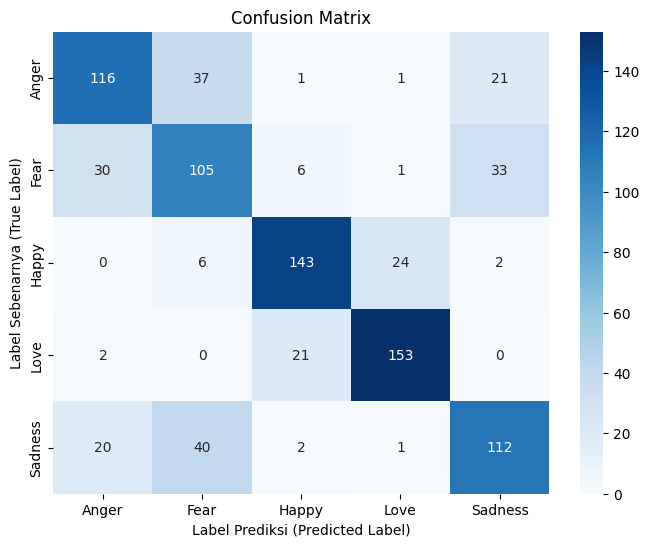

In [ ]:
# 1. Hitung Confusion Matrix
cm = confusion_matrix(y_true_numeric, y_pred_numeric)

# 2. Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.title('Confusion Matrix')
plt.ylabel('Label Sebenarnya (True Label)')
plt.xlabel('Label Prediksi (Predicted Label)')
plt.show()

In [ ]:
# 1. Hitung Classification Report
report = classification_report(
    y_true_numeric,
    y_pred_numeric,
    target_names=target_names,
    output_dict=True
)

# 2. Ekstrak Metrik Macro
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']
macro_f1 = report['macro avg']['f1-score']
overall_accuracy = accuracy_score(y_true_numeric, y_pred_numeric)

# 3. Tampilkan Hasil
print("\n--- Ringkasan Metrik Evaluasi (Macro Average) ---")
print(f"✅ Akurasi Keseluruhan: {overall_accuracy:.4f}")
print(f"✅ Macro Precision:    {macro_precision:.4f}")
print(f"✅ Macro Recall:       {macro_recall:.4f}")
print(f"✅ Macro F1-Score:     {macro_f1:.4f}")

# 4. Tampilkan Laporan Lengkap (untuk referensi)
print("\n--- Detail Classification Report ---")
print(classification_report(y_true_numeric, y_pred_numeric, target_names=target_names))


--- Ringkasan Metrik Evaluasi (Macro Average) ---
✅ Akurasi Keseluruhan: 0.7172
✅ Macro Precision:    0.7184
✅ Macro Recall:       0.7171
✅ Macro F1-Score:     0.7175

--- Detail Classification Report ---
              precision    recall  f1-score   support

       Anger       0.69      0.66      0.67       176
        Fear       0.56      0.60      0.58       175
       Happy       0.83      0.82      0.82       175
        Love       0.85      0.87      0.86       176
     Sadness       0.67      0.64      0.65       175

    accuracy                           0.72       877
   macro avg       0.72      0.72      0.72       877
weighted avg       0.72      0.72      0.72       877



# RoBERTa

In [ ]:
df_balanced_path = "/content/drive/MyDrive/Dataset Emotion Classification/df_balanced (2).csv"

In [ ]:
df_balanced = pd.read_csv(df_balanced_path)

In [ ]:
from sklearn.model_selection import train_test_split

# --- Step 1: Split Train 80% dan Temp 20% ---
train_df, temp_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced["Emotion"],
    random_state=42
)

# --- Step 2: Split Temp 20% menjadi Val 10% + Test 10% ---
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["Emotion"],
    random_state=42
)

print("============== DISTRIBUSI DATA ==============\n")

print("Train size:", len(train_df))
print(train_df['Emotion'].value_counts(), "\n")

print("Validation size:", len(val_df))
print(val_df['Emotion'].value_counts(), "\n")

print("Test size:", len(test_df))
print(test_df['Emotion'].value_counts(), "\n")

============== DISTRIBUSI DATA ==============

Train size: 7012
Emotion
Sadness    1403
Fear       1403
Anger      1402
Happy      1402
Love       1402
Name: count, dtype: int64 

Validation size: 876
Emotion
Happy      176
Sadness    175
Fear       175
Love       175
Anger      175
Name: count, dtype: int64 

Test size: 877
Emotion
Anger      176
Love       176
Fear       175
Sadness    175
Happy      175
Name: count, dtype: int64 



In [ ]:
val_df = val_df[["text_clean", "Emotion"]]

In [ ]:
val_df[val_df.duplicated(subset=["text_clean"])]

text_clean Emotion
6441     Bagus sekali    Love
7242  pengiriman lama   Anger

In [ ]:
val_df = val_df.drop_duplicates(subset=["text_clean"])

In [ ]:
val_df["Emotion"].value_counts()

Emotion
Happy      176
Sadness    175
Fear       175
Love       174
Anger      174
Name: count, dtype: int64

In [ ]:
train_df = train_df[["text_clean", "Emotion"]]

In [ ]:
train_df[train_df.duplicated(subset=["text_clean"])]

text_clean  Emotion
2142                                       mengecewakan  Sadness
7815       pengirimannya memakan waktu yang sangat lama    Anger
6722                                       sangat bagus     Love
4293                                       tidak sesuai     Fear
7679                                       mengecewakan    Anger
3692                      barang tidak sesuai deskripsi     Fear
596                                       barang sesuai    Happy
673          material produk bagus ukuran produk sesuai    Happy
373                                              mantap    Happy
3094                               tidak sesuai harapan  Sadness
6344                                       sangat bagus     Love
8229                             penjualnya tidak ramah    Anger
3183                               layanan mengecewakan  Sadness
1916                                       mengecewakan  Sadness
5766                     fast respon recommended seller     Love
1869                                             kecewa  Sadness
3328                                       tidak sesuai  Sadness
6118                                       sangat bagus     Love
406                                     produk original    Happy
7350                                    tidak berfungsi    Anger
5269                                            top bgt     Love
6440                                       barang padat     Love
6448                                       sangat bagus     Love
2042                             pengiriman sangat lama  Sadness
4826                      barangnya tidak sesuai gambar     Fear
3378                                bahannya tidak enak  Sadness
5929                                       bagus banget     Love
7194                                             kecewa    Anger
952                                    mantap barangnya    Happy
5418                                             mantap     Love
5644                                             mantap     Love
6439                      penjual yang direkomendasikan     Love
3123                                    tidak berfungsi  Sadness
160                                      sesuai pesanan    Happy
5268                                 recommended seller     Love
5920                                       bagus banget     Love
5446                                             mantap     Love
309                          barang sesuai terima kasih    Happy
3267                                      sangat kecewa  Sadness
934                               berfungsi dengan baik    Happy
6245                                       Bagus sekali     Love
6579                      penjual yang direkomendasikan     Love
8065                             pengiriman sangat lama    Anger
3462                             bahannya terlalu tipis  Sadness
4583                   barangnya tidak sesuai deskripsi     Fear
290                               barang sesuai pesanan    Happy
3249                                      sangat kecewa  Sadness
1075  barang sudah sampai pelayanan cepat sekali pac...    Happy
319                        produk berfungsi dengan baik    Happy
6402                                       Bagus sekali     Love
5085                             penjualnya tidak ramah     Fear

In [ ]:
train_df = train_df.drop_duplicates(subset=["text_clean"])

In [ ]:
train_df["Emotion"].value_counts()

Emotion
Fear       1398
Anger      1396
Happy      1391
Sadness    1391
Love       1385
Name: count, dtype: int64

In [ ]:
df_train = train_df
df_val = val_df

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, Dataset
import torch
import numpy as np
import evaluate

# 1. Tentukan Model dan Label
model_name = "cahya/roberta-base-indonesian-522M"
# Ganti dengan label emosi yang sebenarnya dari data Anda, contoh:
label_list = ["Happy", "Anger", "Sadness", "Love", "Fear"]
num_labels = len(label_list)

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["Emotion"])
df_val["label"] = le.transform(df_val["Emotion"])  # pakai transform, bukan fit_transform

In [ ]:
df_train[["Emotion", "label"]].drop_duplicates().sort_values("label")

Emotion  label
8562    Anger      0
3717     Fear      1
1010    Happy      2
6225     Love      3
3471  Sadness      4

In [ ]:
df_val[["Emotion", "label"]].drop_duplicates().sort_values("label")

Emotion  label
7940    Anger      0
4890     Fear      1
539     Happy      2
5687     Love      3
2282  Sadness      4

In [ ]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
label_map

{'Anger': np.int64(0),
 'Fear': np.int64(1),
 'Happy': np.int64(2),
 'Love': np.int64(3),
 'Sadness': np.int64(4)}

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(df_train[["text_clean", "label"]])
val_dataset = Dataset.from_pandas(df_val[["text_clean", "label"]])

In [ ]:
train_dataset = train_dataset.rename_column("text_clean", "text")
val_dataset = val_dataset.rename_column("text_clean", "text")

In [ ]:
def tokenize_function(examples):
    # Ensure sequences are padded to a uniform length and truncated if necessary
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

In [ ]:
# lengths = df_train["text_clean"].apply(lambda x: len(tokenizer.tokenize(x)))
# lengths.describe()

In [ ]:
tokenized_train_data = train_dataset.map(tokenize_function, batched=True)
tokenized_val_data = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6961 [00:00<?, ? examples/s]

Map:   0%|          | 0/874 [00:00<?, ? examples/s]

In [ ]:
cols_to_remove = ["text", "Emotion", "__index_level_0__"]

tokenized_train_data = tokenized_train_data.remove_columns(
    [c for c in cols_to_remove if c in tokenized_train_data.column_names]
)

tokenized_val_data = tokenized_val_data.remove_columns(
    [c for c in cols_to_remove if c in tokenized_val_data.column_names]
)

In [ ]:
from transformers import AutoModelForSequenceClassification
import numpy as np

In [ ]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions, eval_pred.label_ids

    # If predictions is a tuple (e.g., (logits, some_other_output)), take the first element (logits)
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Ensure predictions is a NumPy array. Trainer usually handles this,
    # but explicit conversion can sometimes prevent shape-related errors.
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    # Now, predictions should be a 2D numpy array (num_samples, num_labels)
    # Perform argmax to get the predicted class index for each sample
    preds = np.argmax(predictions, axis=-1)

    f1_macro = metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"f1": f1_macro}

In [ ]:
LEARNING_RATE = 2e-6 # Perlu diatur di TrainingArguments

In [ ]:
from transformers import EarlyStoppingCallback, TrainingArguments

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3
)

In [ ]:
training_args = TrainingArguments(
    output_dir="./finetuning_results", # Ganti nama output folder

    # Hyperparameters
    learning_rate=LEARNING_RATE, # Tetapkan Learning Rate default
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.3, # Tambahkan weight decay default jika tidak di-tune

    # Maks epoch + load model terbaik
    num_train_epochs=20,
    metric_for_best_model="f1",

    load_best_model_at_end=True,

    # Evaluasi dan penyimpanan
    save_strategy="epoch",
    eval_strategy="epoch",

    logging_dir='./finetuning_logs',
    logging_steps=100,
    report_to="none",
)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

DROPOUT_RATE = 0.1

def init_full_finetune_model():
    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=num_labels,
        hidden_dropout_prob=DROPOUT_RATE,
        attention_probs_dropout_prob=DROPOUT_RATE
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
    )

    return model

In [ ]:
from transformers import Trainer

final_model = init_full_finetune_model()

trainer = Trainer(
    model=final_model, # Gunakan model full fine-tuning
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

# 4. Latih Model
print("\n🔥 Memulai Pelatihan Full Fine-Tuning...")
trainer.train()

# 5. Evaluasi Hasil Akhir
print("\n✅ Evaluasi Akhir:")
final_results = trainer.evaluate()
print(final_results)

pytorch_model.bin:   0%|          | 0.00/507M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cahya/roberta-base-indonesian-522M and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔥 Memulai Pelatihan Full Fine-Tuning...


model.safetensors:   0%|          | 0.00/507M [00:00<?, ?B/s]


✅ Evaluasi Akhir:


{'eval_loss': 0.8072859048843384, 'eval_f1': 0.6842383409133113, 'eval_runtime': 11.4441, 'eval_samples_per_second': 76.371, 'eval_steps_per_second': 9.612, 'epoch': 13.0}


# mBERT

In [ ]:
df_balanced_path = "/content/drive/MyDrive/Dataset Emotion Classification/df_balanced (2).csv"

In [ ]:
df_balanced = pd.read_csv(df_balanced_path)

In [ ]:
from sklearn.model_selection import train_test_split

# --- Step 1: Split Train 80% dan Temp 20% ---
train_df, temp_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced["Emotion"],
    random_state=42
)

# --- Step 2: Split Temp 20% menjadi Val 10% + Test 10% ---
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["Emotion"],
    random_state=42
)

print("============== DISTRIBUSI DATA ==============\n")

print("Train size:", len(train_df))
print(train_df['Emotion'].value_counts(), "\n")

print("Validation size:", len(val_df))
print(val_df['Emotion'].value_counts(), "\n")

print("Test size:", len(test_df))
print(test_df['Emotion'].value_counts(), "\n")

============== DISTRIBUSI DATA ==============

Train size: 7012
Emotion
Sadness    1403
Fear       1403
Anger      1402
Happy      1402
Love       1402
Name: count, dtype: int64 

Validation size: 876
Emotion
Happy      176
Sadness    175
Fear       175
Love       175
Anger      175
Name: count, dtype: int64 

Test size: 877
Emotion
Anger      176
Love       176
Fear       175
Sadness    175
Happy      175
Name: count, dtype: int64 



In [ ]:
# Tentukan path file
output_path = '/content/drive/MyDrive/Dataset Emotion Classification/test bert.csv'

# Simpan dataframe ke CSV
test_df.to_csv(output_path, index=False)

print(f"File berhasil disimpan di: {output_path}")

File berhasil disimpan di: /content/drive/MyDrive/Dataset Emotion Classification/test bert.csv


In [ ]:
val_df = val_df[["text_clean", "Emotion"]]

In [ ]:
val_df[val_df.duplicated(subset=["text_clean"])]

text_clean Emotion
6441     Bagus sekali    Love
7242  pengiriman lama   Anger

In [ ]:
val_df = val_df.drop_duplicates(subset=["text_clean"])

In [ ]:
val_df["Emotion"].value_counts()

Emotion
Happy      176
Sadness    175
Fear       175
Love       174
Anger      174
Name: count, dtype: int64

In [ ]:
train_df = train_df[["text_clean", "Emotion"]]

In [ ]:
train_df[train_df.duplicated(subset=["text_clean"])]

text_clean  Emotion
2142                                       mengecewakan  Sadness
7815       pengirimannya memakan waktu yang sangat lama    Anger
6722                                       sangat bagus     Love
4293                                       tidak sesuai     Fear
7679                                       mengecewakan    Anger
3692                      barang tidak sesuai deskripsi     Fear
596                                       barang sesuai    Happy
673          material produk bagus ukuran produk sesuai    Happy
373                                              mantap    Happy
3094                               tidak sesuai harapan  Sadness
6344                                       sangat bagus     Love
8229                             penjualnya tidak ramah    Anger
3183                               layanan mengecewakan  Sadness
1916                                       mengecewakan  Sadness
5766                     fast respon recommended seller     Love
1869                                             kecewa  Sadness
3328                                       tidak sesuai  Sadness
6118                                       sangat bagus     Love
406                                     produk original    Happy
7350                                    tidak berfungsi    Anger
5269                                            top bgt     Love
6440                                       barang padat     Love
6448                                       sangat bagus     Love
2042                             pengiriman sangat lama  Sadness
4826                      barangnya tidak sesuai gambar     Fear
3378                                bahannya tidak enak  Sadness
5929                                       bagus banget     Love
7194                                             kecewa    Anger
952                                    mantap barangnya    Happy
5418                                             mantap     Love
5644                                             mantap     Love
6439                      penjual yang direkomendasikan     Love
3123                                    tidak berfungsi  Sadness
160                                      sesuai pesanan    Happy
5268                                 recommended seller     Love
5920                                       bagus banget     Love
5446                                             mantap     Love
309                          barang sesuai terima kasih    Happy
3267                                      sangat kecewa  Sadness
934                               berfungsi dengan baik    Happy
6245                                       Bagus sekali     Love
6579                      penjual yang direkomendasikan     Love
8065                             pengiriman sangat lama    Anger
3462                             bahannya terlalu tipis  Sadness
4583                   barangnya tidak sesuai deskripsi     Fear
290                               barang sesuai pesanan    Happy
3249                                      sangat kecewa  Sadness
1075  barang sudah sampai pelayanan cepat sekali pac...    Happy
319                        produk berfungsi dengan baik    Happy
6402                                       Bagus sekali     Love
5085                             penjualnya tidak ramah     Fear

In [ ]:
train_df = train_df.drop_duplicates(subset=["text_clean"])

In [ ]:
train_df["Emotion"].value_counts()

Emotion
Fear       1398
Anger      1396
Happy      1391
Sadness    1391
Love       1385
Name: count, dtype: int64

In [ ]:
df_train = train_df
df_val = val_df

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, Dataset
import torch
import numpy as np
import evaluate

# 1. Tentukan Model dan Label
model_name = "google-bert/bert-base-multilingual-uncased"
# Ganti dengan label emosi yang sebenarnya dari data Anda, contoh:
label_list = ["Happy", "Anger", "Sadness", "Love", "Fear"]
num_labels = len(label_list)

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["Emotion"])
df_val["label"] = le.transform(df_val["Emotion"])  # pakai transform, bukan fit_transform

In [ ]:
df_train[["Emotion", "label"]].drop_duplicates().sort_values("label")

Emotion  label
8562    Anger      0
3717     Fear      1
1010    Happy      2
6225     Love      3
3471  Sadness      4

In [ ]:
df_val[["Emotion", "label"]].drop_duplicates().sort_values("label")

Emotion  label
7940    Anger      0
4890     Fear      1
539     Happy      2
5687     Love      3
2282  Sadness      4

In [ ]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
label_map

{'Anger': np.int64(0),
 'Fear': np.int64(1),
 'Happy': np.int64(2),
 'Love': np.int64(3),
 'Sadness': np.int64(4)}

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(df_train[["text_clean", "label"]])
val_dataset = Dataset.from_pandas(df_val[["text_clean", "label"]])

In [ ]:
train_dataset = train_dataset.rename_column("text_clean", "text")
val_dataset = val_dataset.rename_column("text_clean", "text")

In [ ]:
def tokenize_function(examples):
    # Ensure sequences are padded to a uniform length and truncated if necessary
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

In [ ]:
# lengths = df_train["text_clean"].apply(lambda x: len(tokenizer.tokenize(x)))
# lengths.describe()

In [ ]:
tokenized_train_data = train_dataset.map(tokenize_function, batched=True)
tokenized_val_data = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6961 [00:00<?, ? examples/s]

Map:   0%|          | 0/874 [00:00<?, ? examples/s]

In [ ]:
cols_to_remove = ["text", "Emotion", "__index_level_0__"]

tokenized_train_data = tokenized_train_data.remove_columns(
    [c for c in cols_to_remove if c in tokenized_train_data.column_names]
)

tokenized_val_data = tokenized_val_data.remove_columns(
    [c for c in cols_to_remove if c in tokenized_val_data.column_names]
)

In [ ]:
from transformers import AutoModelForSequenceClassification
import numpy as np

In [ ]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions, eval_pred.label_ids

    # If predictions is a tuple (e.g., (logits, some_other_output)), take the first element (logits)
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Ensure predictions is a NumPy array. Trainer usually handles this,
    # but explicit conversion can sometimes prevent shape-related errors.
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    # Now, predictions should be a 2D numpy array (num_samples, num_labels)
    # Perform argmax to get the predicted class index for each sample
    preds = np.argmax(predictions, axis=-1)

    f1_macro = metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    return {"f1": f1_macro}

In [ ]:
LEARNING_RATE = 2e-6 # Perlu diatur di TrainingArguments

In [ ]:
from transformers import EarlyStoppingCallback, TrainingArguments

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3
)

In [ ]:
training_args = TrainingArguments(
    output_dir="./finetuning_results", # Ganti nama output folder

    # Hyperparameters
    learning_rate=LEARNING_RATE, # Tetapkan Learning Rate default
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.3, # Tambahkan weight decay default jika tidak di-tune

    # Maks epoch + load model terbaik
    num_train_epochs=20,
    metric_for_best_model="f1",

    load_best_model_at_end=True,

    # Evaluasi dan penyimpanan
    save_strategy="epoch",
    eval_strategy="epoch",

    logging_dir='./finetuning_logs',
    logging_steps=100,
    report_to="none",
)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

DROPOUT_RATE = 0.1

def init_full_finetune_model():
    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=num_labels,
        hidden_dropout_prob=DROPOUT_RATE,
        attention_probs_dropout_prob=DROPOUT_RATE
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
    )

    return model

In [ ]:
from transformers import Trainer

final_model = init_full_finetune_model()

trainer = Trainer(
    model=final_model, # Gunakan model full fine-tuning
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

# 4. Latih Model
print("\n🔥 Memulai Pelatihan Full Fine-Tuning...")
trainer.train()

# 5. Evaluasi Hasil Akhir
print("\n✅ Evaluasi Akhir:")
final_results = trainer.evaluate()
print(final_results)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔥 Memulai Pelatihan Full Fine-Tuning...



✅ Evaluasi Akhir:


{'eval_loss': 0.8501887321472168, 'eval_f1': 0.7074947757815142, 'eval_runtime': 12.0049, 'eval_samples_per_second': 72.803, 'eval_steps_per_second': 9.163, 'epoch': 20.0}
